<a href="https://colab.research.google.com/github/vincelemke99/Calculator/blob/main/finales_lead_predication_target_encoder_3_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install pandas category_encoders scikit-learn tensorflow --q
!pip install tensorflow==2.12.0 --q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 81.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 52.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 75.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 42.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.86 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
pandas-stubs 2.0.3.230814 requires numpy>=1.25.0; python_version >= "3.9", but you have numpy 1.23.5 which is incompatible.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.12.0 which is incompatible.


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

# Import machine learning libraries
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix
)
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif

In [3]:
from google.colab import auth
auth.authenticate_user()
print("Authenticated")

Authenticated


In [4]:
PROJECT_ID = 'prj-snd-ew3-vschmitt'

In [5]:
from google.cloud import bigquery
client = bigquery.Client(project=PROJECT_ID)

In [6]:
BQ_PROJECT = PROJECT_ID
BQ_DATASET = 'lead_prediction'
BQ_TABLE = 'trainings_data'

In [7]:
# SQL query to select data
query = f"""
SELECT *
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
"""

try:
    # Execute the query and convert the result to a pandas DataFrame
    df = client.query(query=query).to_dataframe()
    print("Query executed successfully and DataFrame is ready.")
except Exception as e:
    print(f"An error occurred: {e}")

Query executed successfully and DataFrame is ready.


In [8]:
df.shape

(210811, 18)

In [9]:
df.head()

,Lead_ID,Lead_Source,Lead_Source_Detail,Name_Case,Domain_Type,Gender,Host,has_Phone,Accept_Data_Policy,Conversion_Type,Study_Model,Type_of_Study_Program,Study_Location,Faculty,Study_Program,Semester,is_converted,Sum_of_Study_Interests
0,00Q7U000003RdpLUAS,Organisch,Bing,normal,Common Domain,weiblich,www.amdnet.de,False,False,None,Berufsbegleitend,Weiterbildung,Berlin,Fachbereich Design,Styling,Wintersemester,False,1
1,00Q7U000005NeSiUAK,Organisch,Bing,lowercase,Common Domain,weiblich,www.amdnet.de,False,False,Infomaterial,Berufsbegleitend,Weiterbildung,Hamburg,Fachbereich Design,Styling,Wintersemester,False,1
2,00Q7U0000034VNWUA2,Organisch,Bing,normal,Common Domain,weiblich,www.amdnet.de,False,False,None,Berufsbegleitend,Weiterbildung,München,Fachbereich Design,Styling,Sommersemester,False,1
3,00Q7U000006uQDGUA2,Organisch,Bing,normal,Common Domain,weiblich,www.amdnet.de,False,False,Infomaterial,Berufsbegleitend,Weiterbildung,München,Fachbereich Design,Styling,Sommersemester,False,1
4,00Q7U000008l7alUAA,Organisch,Bing,normal,Common Domain,weiblich,www.amdnet.de,False,False,Infomaterial,Berufsbegleitend,Weiterbildung,Hamburg,Fachbereich Design,Styling,Wintersemester,True,1


In [10]:
df.drop(['Lead_ID',], axis="columns", inplace=True)

In [11]:
df.rename(columns={'Lead_Source' : 'Lead Source', 'Lead_Source_Detail' : 'Lead Source Detail',
                   'Name_Case' : 'Name Case', 'has_Phone' : 'has Phone', 'Accept_Data_Policy' : 'Accept Data Policy',
                   'Conversion_Type' : 'Conversion Type', 'Study_Model' : 'Study Model', 'Type_of_Study_Program' : 'Type of Study Program',
                   'Study_Location' : 'Study Location', 'Study_Program' : 'Study Program', 'Sum_of_Study_Interests' : 'Sum of Study Interests' , 'Domain_Type' : 'Domain Type' },inplace=True)


In [12]:
df.head()

,Lead Source,Lead Source Detail,Name Case,Domain Type,Gender,Host,has Phone,Accept Data Policy,Conversion Type,Study Model,Type of Study Program,Study Location,Faculty,Study Program,Semester,is_converted,Sum of Study Interests
0,Organisch,Bing,normal,Common Domain,weiblich,www.amdnet.de,False,False,None,Berufsbegleitend,Weiterbildung,Berlin,Fachbereich Design,Styling,Wintersemester,False,1
1,Organisch,Bing,lowercase,Common Domain,weiblich,www.amdnet.de,False,False,Infomaterial,Berufsbegleitend,Weiterbildung,Hamburg,Fachbereich Design,Styling,Wintersemester,False,1
2,Organisch,Bing,normal,Common Domain,weiblich,www.amdnet.de,False,False,None,Berufsbegleitend,Weiterbildung,München,Fachbereich Design,Styling,Sommersemester,False,1
3,Organisch,Bing,normal,Common Domain,weiblich,www.amdnet.de,False,False,Infomaterial,Berufsbegleitend,Weiterbildung,München,Fachbereich Design,Styling,Sommersemester,False,1
4,Organisch,Bing,normal,Common Domain,weiblich,www.amdnet.de,False,False,Infomaterial,Berufsbegleitend,Weiterbildung,Hamburg,Fachbereich Design,Styling,Wintersemester,True,1


In [13]:
df.isna().sum().to_frame(name='Missing Values').sort_values('Missing Values', ascending=False)

,Missing Values
Host,40591
Conversion Type,39412
Gender,3738
Lead Source,0
Lead Source Detail,0
Domain Type,0
Name Case,0
has Phone,0
Accept Data Policy,0
Study Model,0


In [14]:
# Calculate the percentage of missing values for each column
percentage_missing = df.isnull().sum() * 100 / len(df)
# Create a DataFrame to display the missing values
missing_values_df = percentage_missing.to_frame(name='Missing Values').sort_values('Missing Values', ascending=False)
# Display the DataFrame
missing_values_df

,Missing Values
Host,19.254688
Conversion Type,18.695419
Gender,1.773152
Lead Source,0.000000
Lead Source Detail,0.000000
Domain Type,0.000000
Name Case,0.000000
has Phone,0.000000
Accept Data Policy,0.000000
Study Model,0.000000


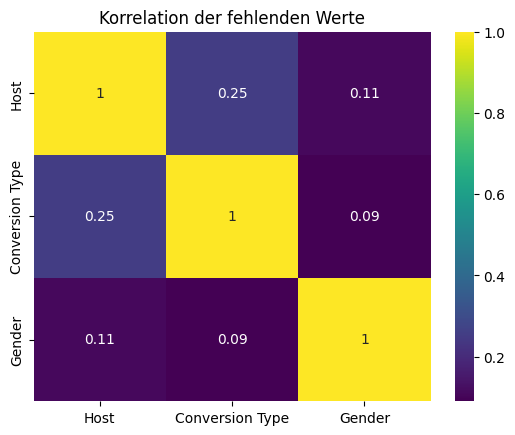

In [15]:
# Korrelation zwischen den fehlenden Werten
correlation_matrix = df[['Host', 'Conversion Type', 'Gender']].isnull().corr()
sns.heatmap(correlation_matrix, annot=True, cmap='viridis')
plt.title('Korrelation der fehlenden Werte')
plt.show()


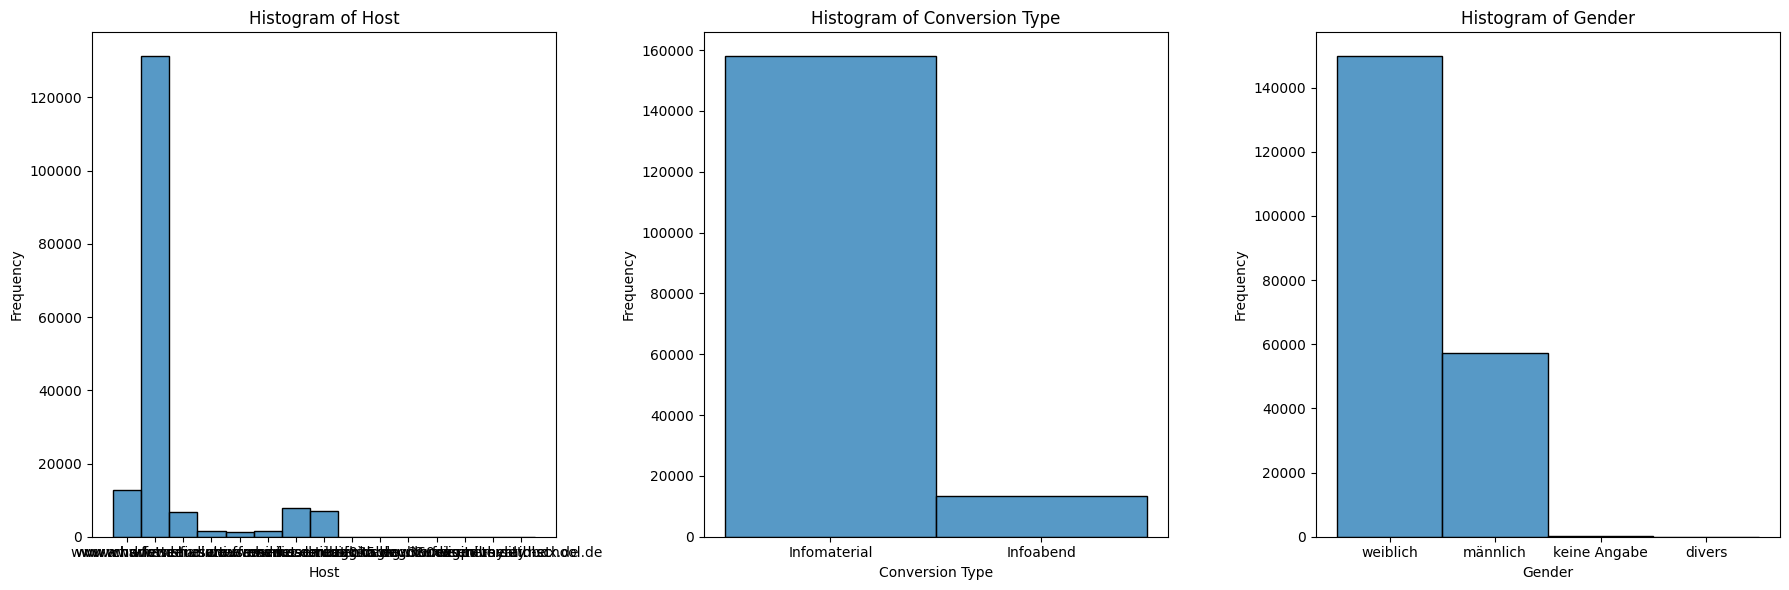

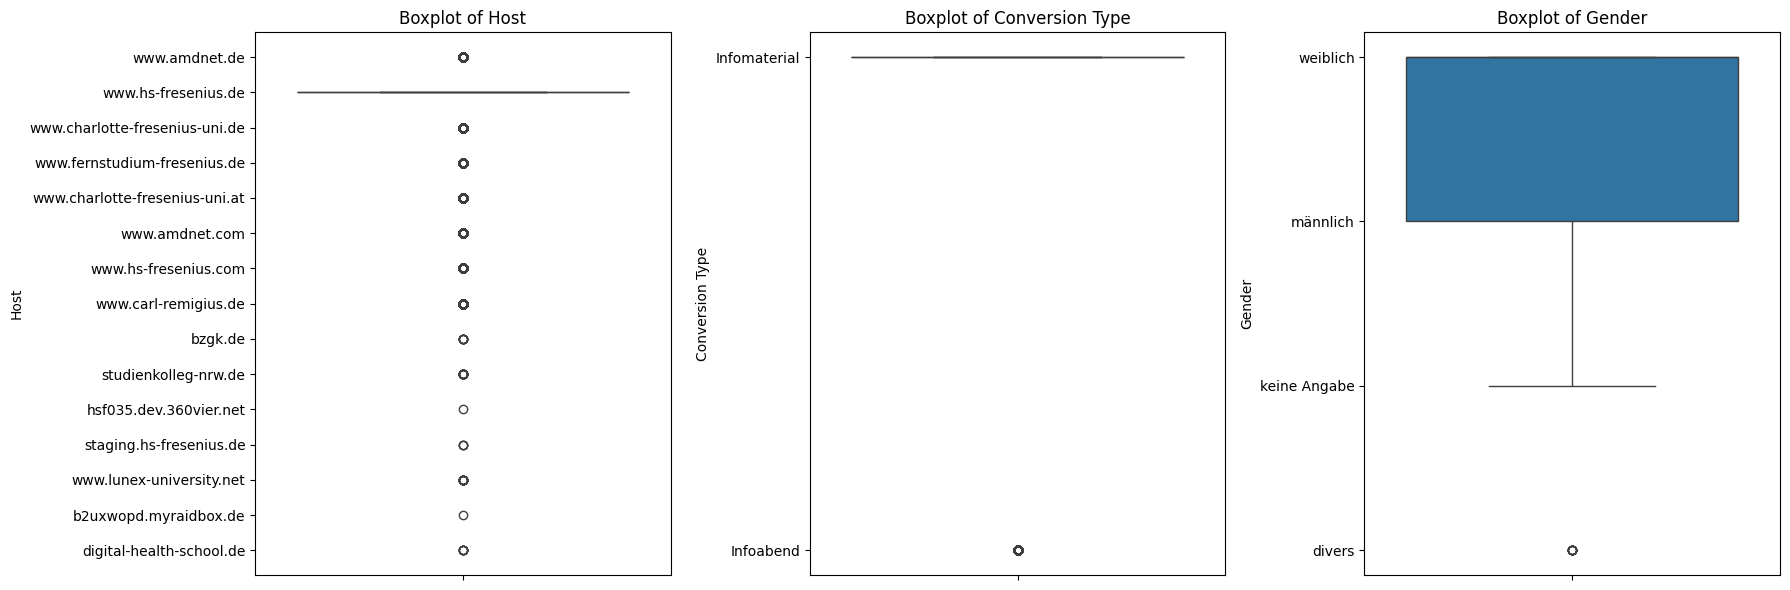

In [16]:
# Histogramme
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, column in enumerate(['Host', 'Conversion Type', 'Gender']):
    sns.histplot(df[column], kde=False, ax=axes[i])
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Boxplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, column in enumerate(['Host', 'Conversion Type', 'Gender']):
    sns.boxplot(y=df[column], ax=axes[i])
    axes[i].set_title(f'Boxplot of {column}')
    axes[i].set_ylabel(column)

plt.tight_layout()
plt.show()

In [17]:
df['Host'].value_counts()

Host
www.hs-fresenius.de               131236
www.amdnet.de                      12679
www.hs-fresenius.com                7917
www.carl-remigius.de                7067
www.charlotte-fresenius-uni.de      6886
www.amdnet.com                      1578
www.fernstudium-fresenius.de        1503
www.charlotte-fresenius-uni.at      1297
studienkolleg-nrw.de                  23
www.lunex-university.net              16
bzgk.de                                7
digital-health-school.de               6
staging.hs-fresenius.de                3
hsf035.dev.360vier.net                 1
b2uxwopd.myraidbox.de                  1
Name: count, dtype: int64

In [18]:
unwanted_hosts = ['staging.hs-fresenius.de', 'hsf035.dev.360vier.net', 'b2uxwopd.myraidbox.de', 'digital-health-school.de']

# Filter the DataFrame
df = df[~df['Host'].isin(unwanted_hosts)]

In [19]:
unwanted_Lead_Source = ['-149307507Publisher', 'Not Found']

# Filter the DataFrame
df = df[~df['Lead Source'].isin(unwanted_Lead_Source )]

In [20]:
df['Conversion Type'] = df['Conversion Type'].fillna('Infomaterial')

In [21]:
df['Gender'] = df['Gender'].fillna('weiblich')

In [22]:
df['Host'] = df['Host'].fillna('www.hs-fresenius.de')

In [23]:
# Calculate the percentage of missing values for each column
percentage_missing = df.isnull().sum() * 100 / len(df)
# Create a DataFrame to display the missing values
missing_values_df = percentage_missing.to_frame(name='Missing Values').sort_values('Missing Values', ascending=False)
# Display the DataFrame
missing_values_df

,Missing Values
Lead Source,0.0
Lead Source Detail,0.0
Name Case,0.0
Domain Type,0.0
Gender,0.0
Host,0.0
has Phone,0.0
Accept Data Policy,0.0
Conversion Type,0.0
Study Model,0.0


In [24]:
df.describe()

,Sum of Study Interests
count,210797.0
mean,1.05613
std,0.279028
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,16.0


In [25]:
df.isna().sum().to_frame(name='Missing Values').sort_values('Missing Values', ascending=False)

,Missing Values
Lead Source,0
Lead Source Detail,0
Name Case,0
Domain Type,0
Gender,0
Host,0
has Phone,0
Accept Data Policy,0
Conversion Type,0
Study Model,0


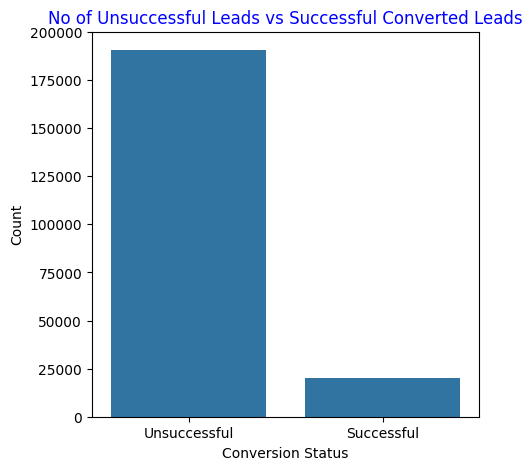

In [26]:
plt.figure(figsize=(5,5))
sns.countplot(x='is_converted', data=df)
plt.title('No of Unsuccessful Leads vs Successful Converted Leads', color='blue')
plt.xticks(np.arange(2), ('Unsuccessful', 'Successful'))
plt.xlabel('Conversion Status')
plt.ylabel('Count')
plt.show()

In [27]:
total_leads = len(df)
successful_leads = df['is_converted'].sum()
conversion_rate = (successful_leads / total_leads) * 100
print(f'Conversion Rate: {conversion_rate:.2f}%')

Conversion Rate: 9.60%


In [28]:
# Creating a crosstab DataFrame for demonstration
crosstab_df = pd.crosstab(index=df['Lead Source'], columns='count')

In [29]:
def plot_frequency_and_percentage(feature, df, category_df, another_row=False, height=8, ylabels=[]):
    if another_row:
        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, height * 2))
    else:
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 6))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    # Get top 5 categories by frequency
    top_categories = category_df[feature].value_counts().nlargest(5).index

    # Frequency plot for top 5 categories
    ax1.set_title(f'Frequency Plot of {feature}', color='blue')
    ax1.set_ylabel(feature)
    ax1.set_xlabel('count')
    sns.countplot(y=feature, data=category_df[category_df[feature].isin(top_categories)],
                  order=top_categories, ax=ax1, color='green')
    if ylabels:
        ax1.set_yticklabels(ylabels)

    # Calculate count of converted leads for top 5 categories
    converted_counts = df[df['is_converted'] == True][feature].value_counts()
    converted_counts = converted_counts[converted_counts.index.isin(top_categories)]

    # Converted leads plot for top 5 categories
    ax2.set_title('Converted Leads Count', color='blue')
    ax2.set_ylabel(feature)
    ax2.set_xlabel('count')
    converted_counts.sort_values().plot(kind='barh', ax=ax2, color='orange')
    if ylabels:
        ax2.set_yticklabels(ylabels)

    # Calculate and display overall conversion rate
    total_leads = len(df)
    successful_leads = df['is_converted'].sum()
    conversion_rate = (successful_leads / total_leads) * 100
    fig.suptitle(f'Overall Conversion Rate: {conversion_rate:.2f}%', fontsize=14, color='red')


plt.show()

In [30]:

def plot_conversion_rate(df, is_converted_column, feature):
    """
    Plots the conversion rate for a specified feature.

    Parameters:
    df (DataFrame): The dataframe containing the data.
    is_converted_column (str): The name of the column indicating if a conversion occurred.
    feature (str): The feature for which to calculate and plot the conversion rate.
    """
    # Filter data where is_converted is True
    df_converted = df[df[is_converted_column] == True]

    # Calculate the count of conversions for each unique value in the feature
    converted_counts = df_converted[feature].value_counts()

    # Calculate the percentage of each unique value within the converted data
    conversion_rate = (converted_counts / converted_counts.sum()) * 100
    conversion_rate = conversion_rate.sort_values(ascending=False)

    # Plot bar chart
    plt.figure(figsize=(10, 6))
    conversion_rate.plot(kind='bar')
    plt.title(f'Percentage of Converted Users by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Percentage of Converted Users (%)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

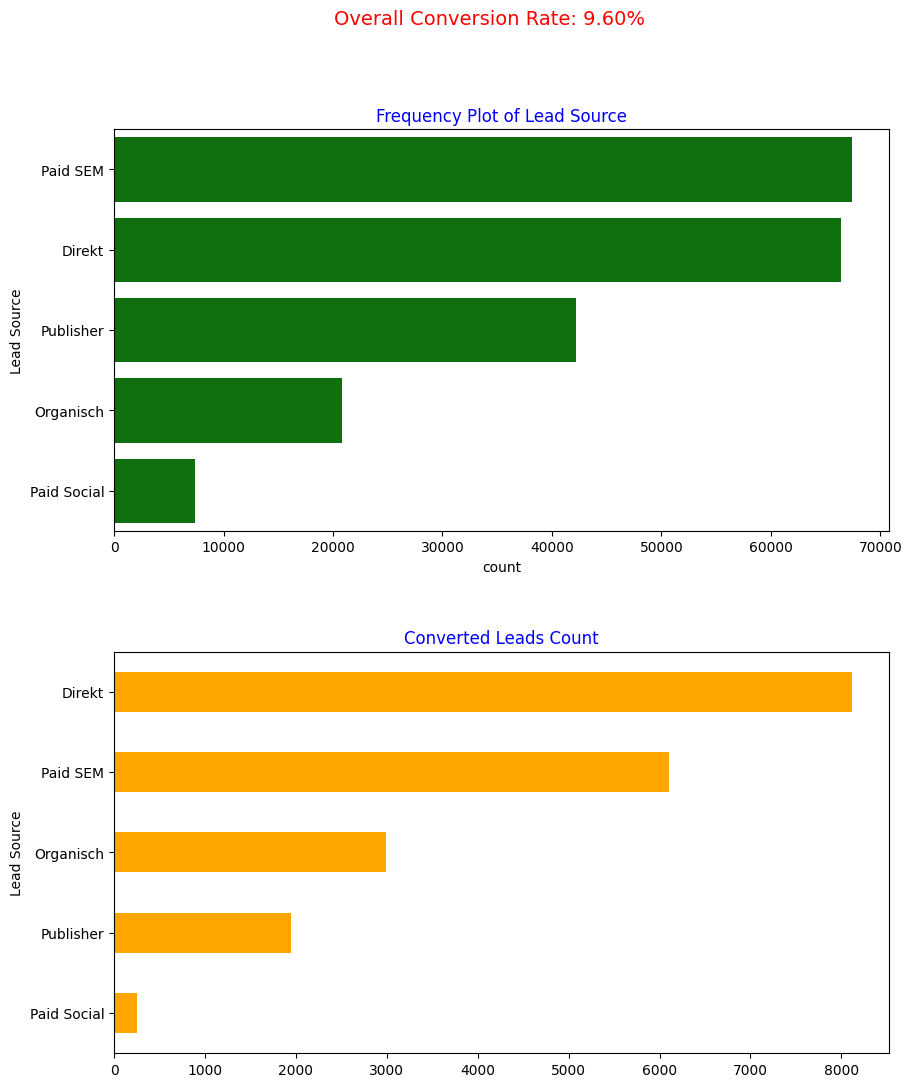

In [31]:
plot_frequency_and_percentage('Lead Source', df, df, True, 6)

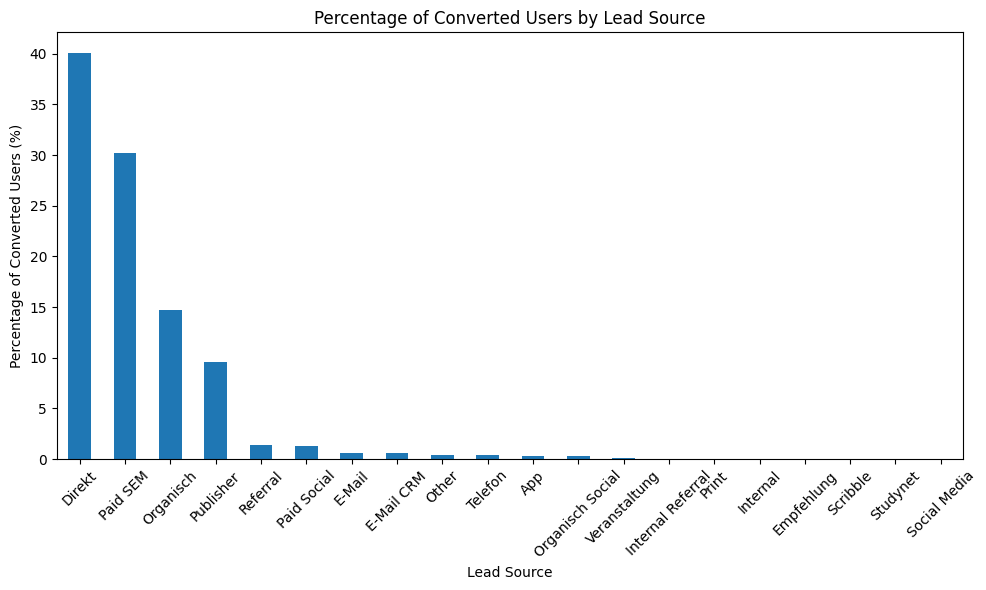

In [32]:
plot_conversion_rate(df, 'is_converted', 'Lead Source')

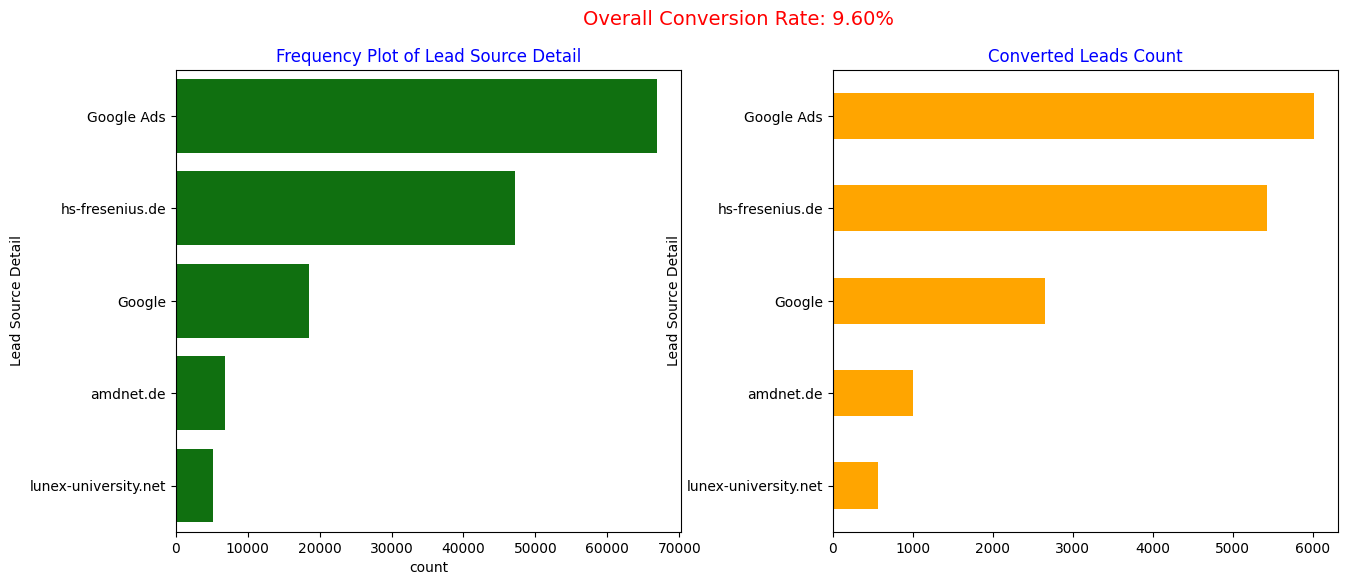

In [33]:
#plot_frequency_and_percentage('Lead_Source_Detail', df, df, True, 6)
plot_frequency_and_percentage('Lead Source Detail', df, df, another_row=False, height=8, ylabels=[])

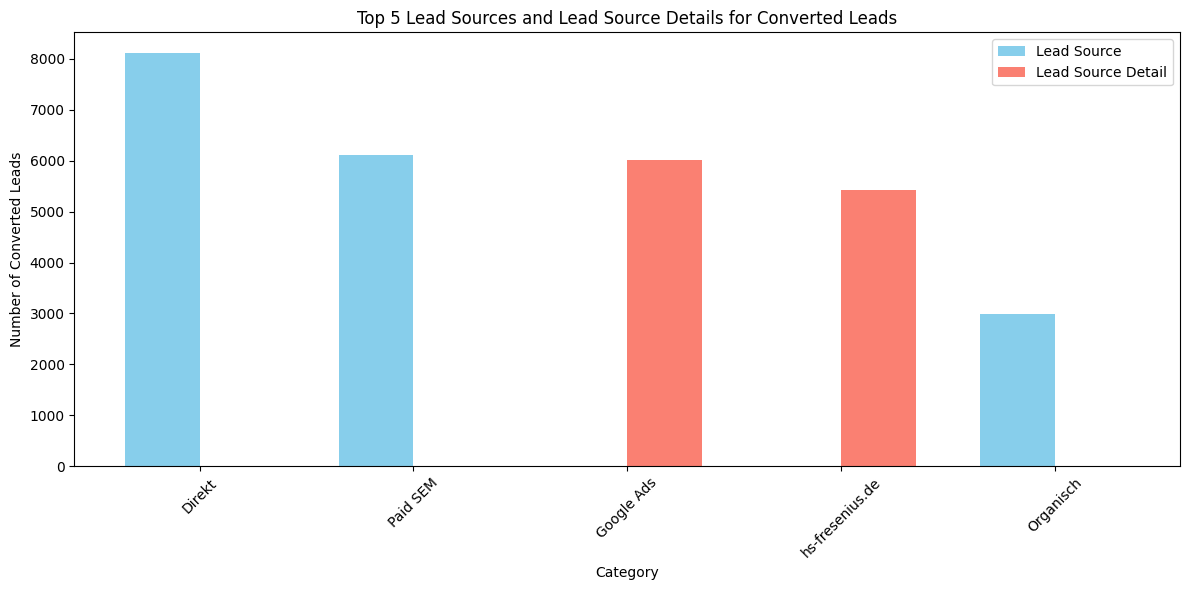

In [34]:
# Filter for converted leads
converted_leads = df[df['is_converted'] == True]

# Aggregate the data for Lead Source and Lead Source Detail
lead_source_counts = converted_leads['Lead Source'].value_counts()
lead_source_detail_counts = converted_leads['Lead Source Detail'].value_counts()

# Combine the counts into a DataFrame
combined_counts = pd.concat([lead_source_counts, lead_source_detail_counts], axis=1).fillna(0)
combined_counts.columns = ['Lead Source', 'Lead Source Detail']

# Select the top 5 categories overall
top_combined_counts = combined_counts.sum(axis=1).nlargest(5)
top_combined_counts = combined_counts.loc[top_combined_counts.index]

# Create the bar chart
fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.35
index = range(len(top_combined_counts))

# Plot Lead Source bars
lead_source_bars = ax.bar(index, top_combined_counts['Lead Source'], bar_width, label='Lead Source', color='skyblue')

# Plot Lead Source Detail bars next to Lead Source bars
lead_source_detail_bars = ax.bar([i + bar_width for i in index], top_combined_counts['Lead Source Detail'], bar_width, label='Lead Source Detail', color='salmon')

# Add labels, title, and legend
ax.set_xlabel('Category')
ax.set_ylabel('Number of Converted Leads')
ax.set_title('Top 5 Lead Sources and Lead Source Details for Converted Leads')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(top_combined_counts.index, rotation=45)
ax.legend()

plt.tight_layout()
plt.show()

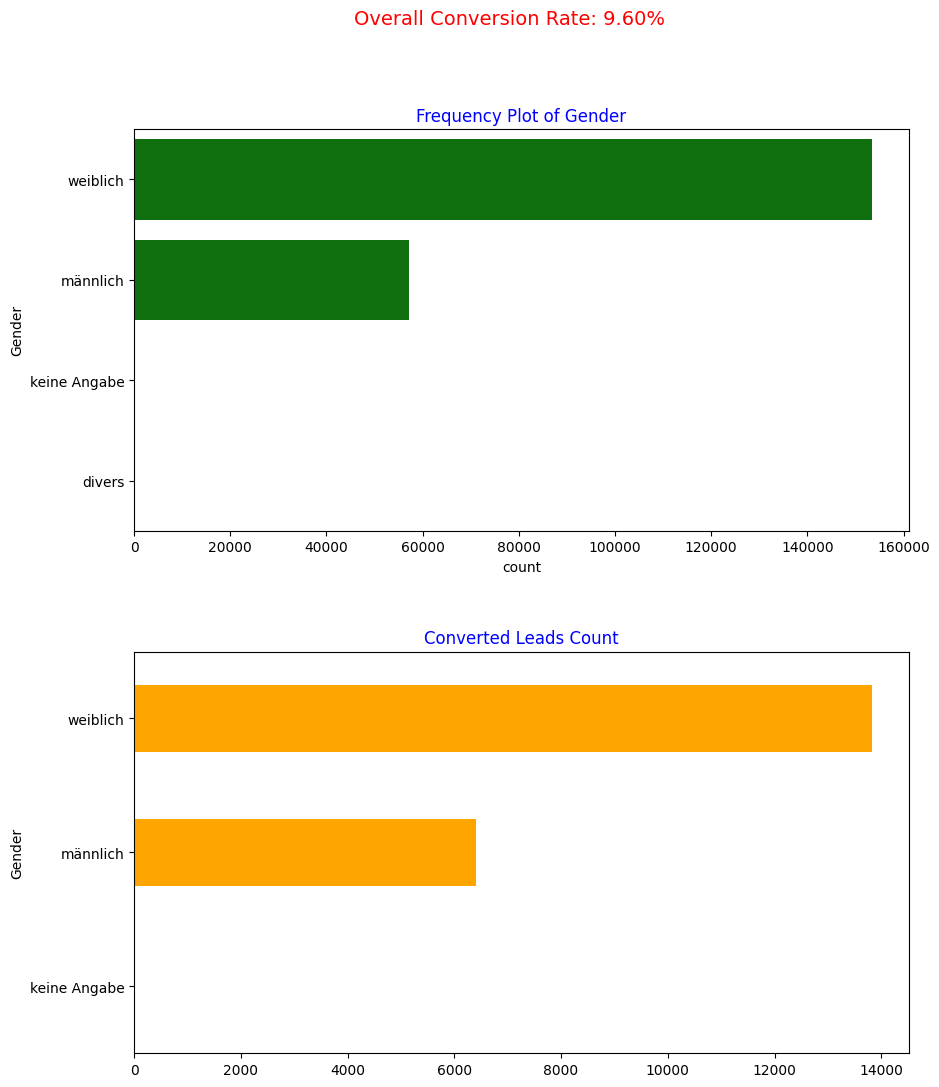

In [35]:
plot_frequency_and_percentage('Gender', df, df, True, 6)

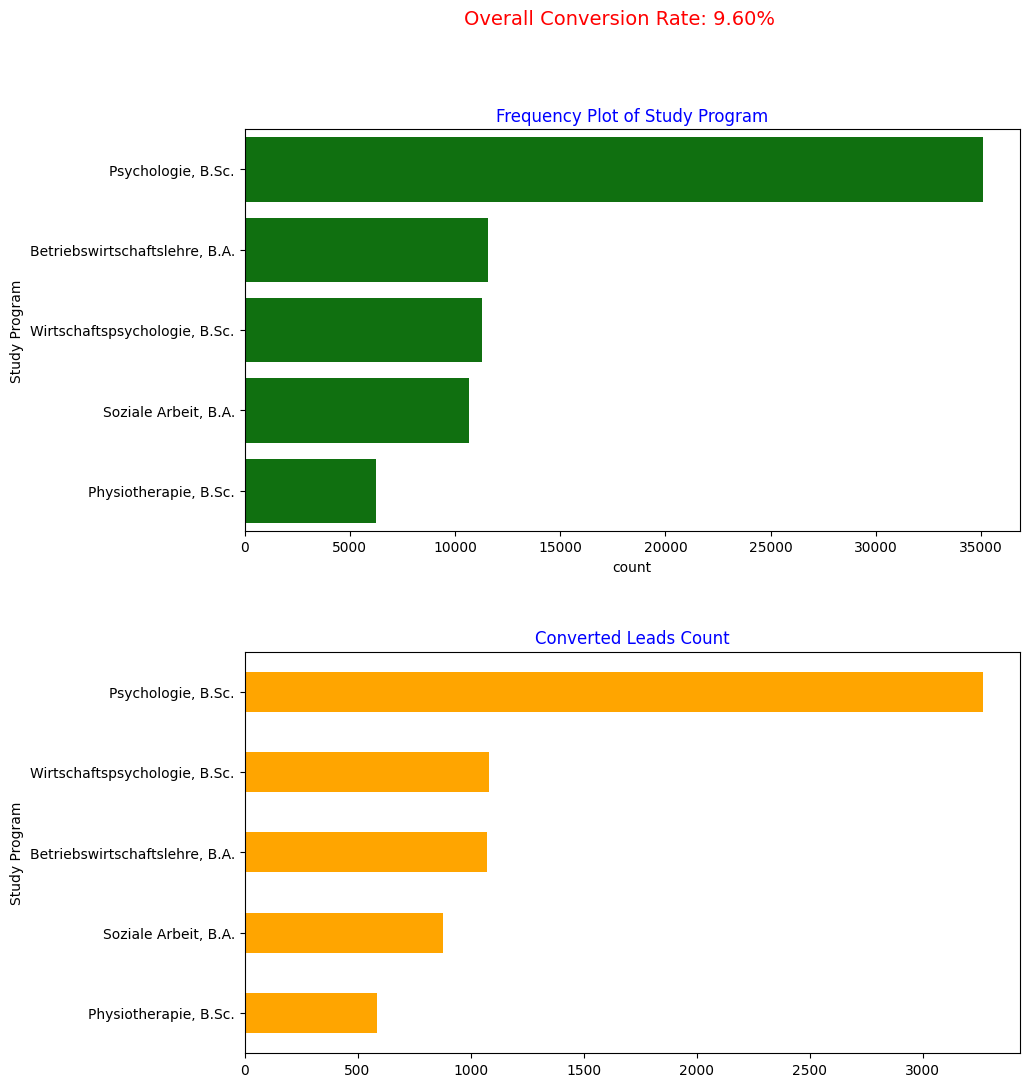

In [36]:
plot_frequency_and_percentage('Study Program', df, df, True, 6)

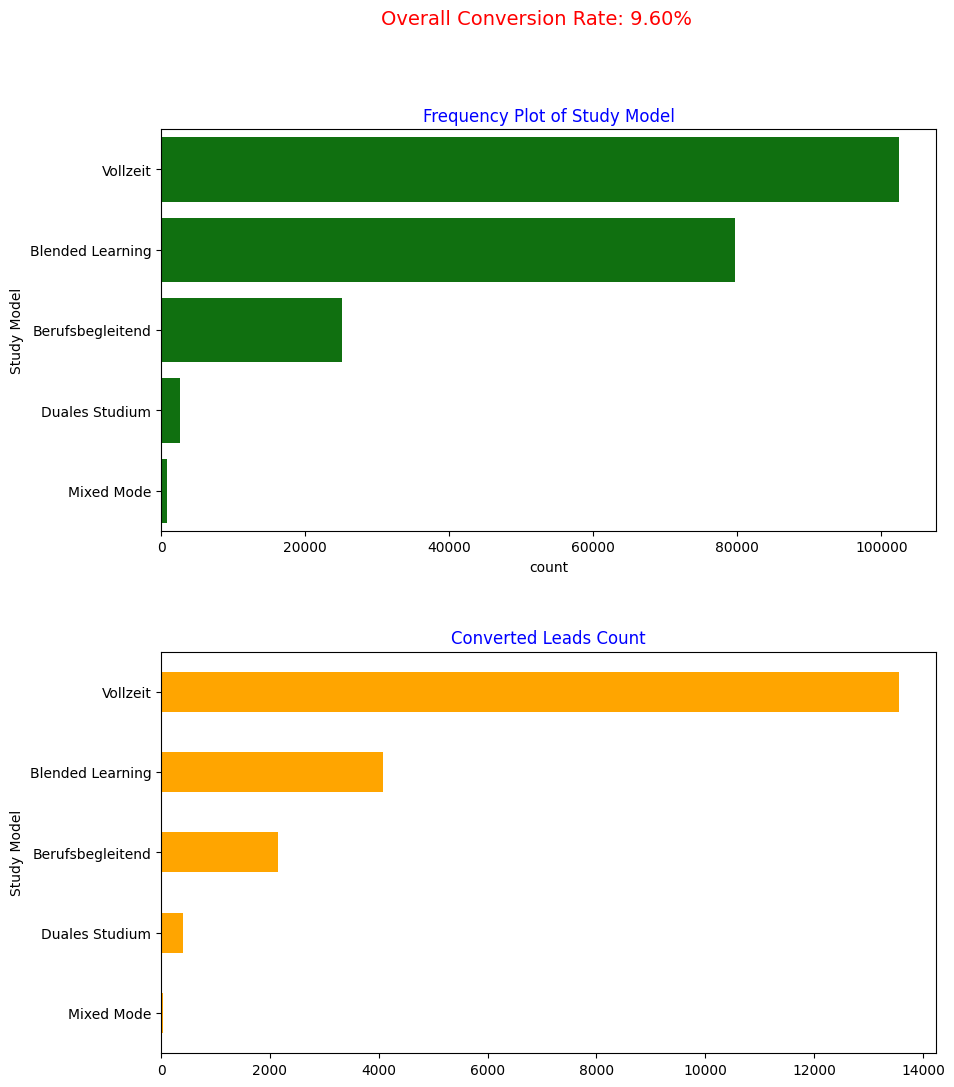

In [37]:
plot_frequency_and_percentage('Study Model', df, df, True, 6)

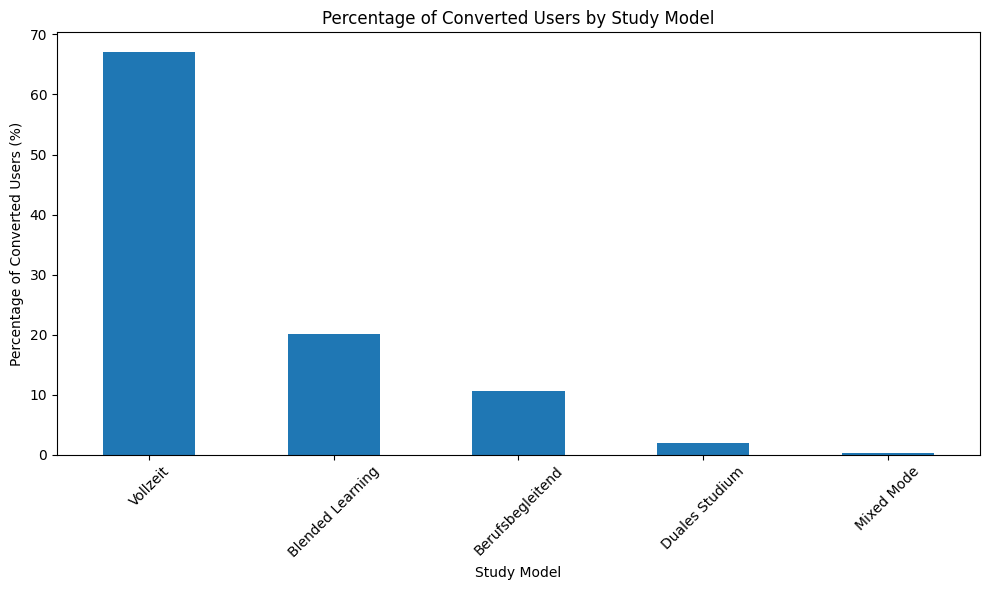

In [38]:
plot_conversion_rate(df, 'is_converted', 'Study Model')

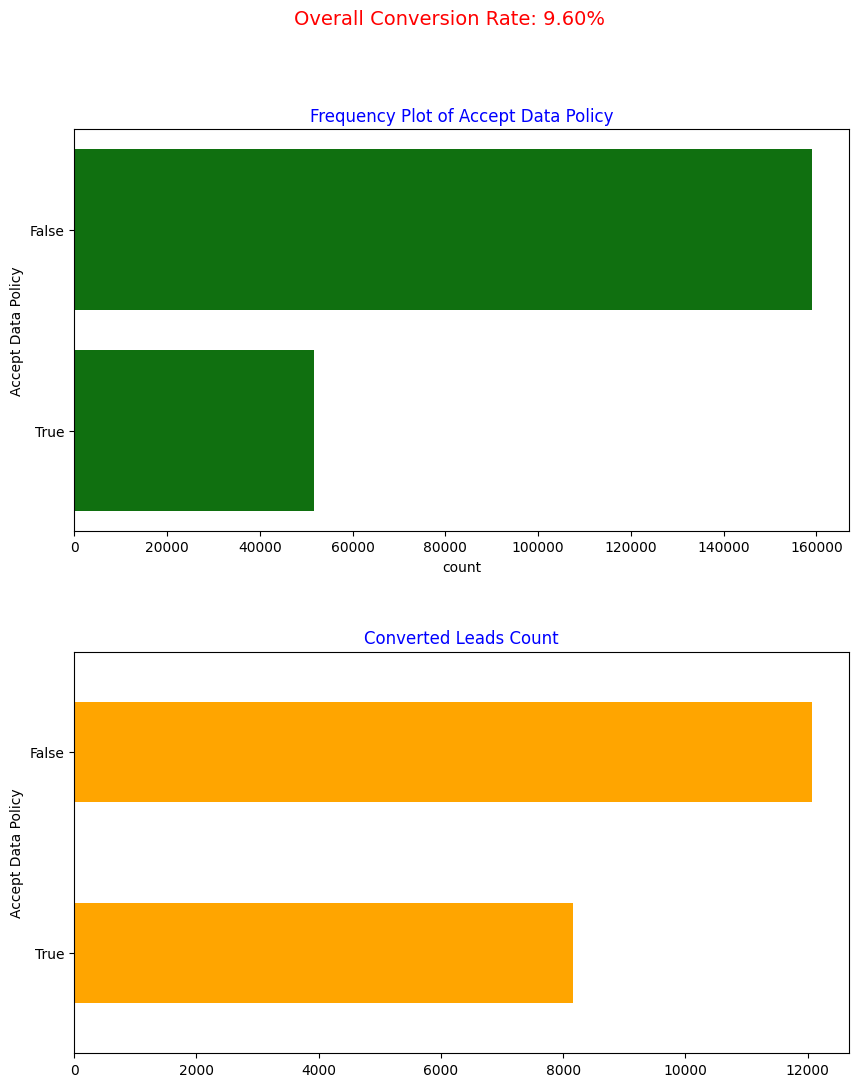

In [39]:
plot_frequency_and_percentage('Accept Data Policy', df, df, True, 6)

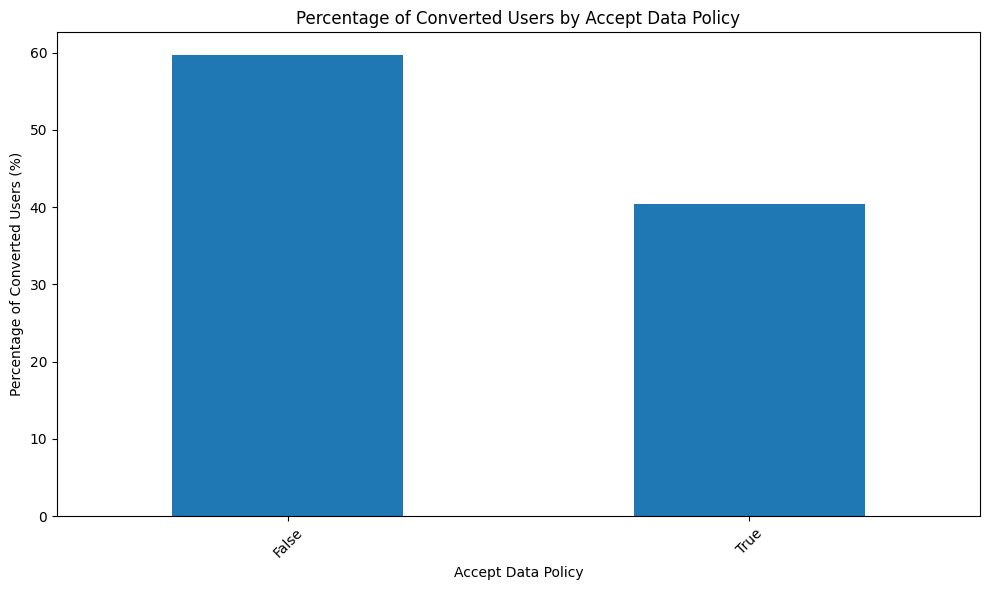

In [40]:
plot_conversion_rate(df, 'is_converted', 'Accept Data Policy')

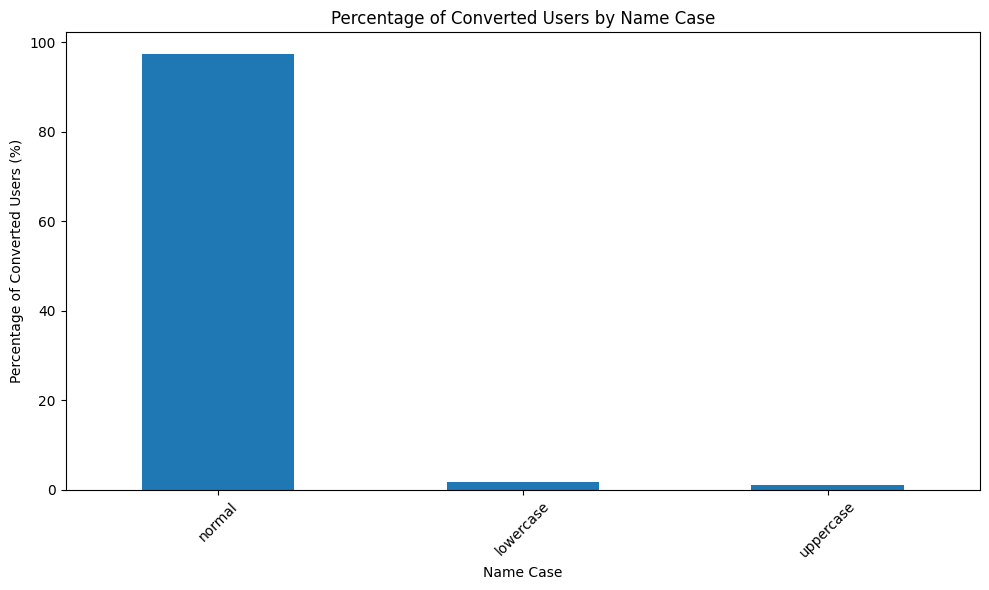

In [41]:
plot_conversion_rate(df, 'is_converted', 'Name Case')

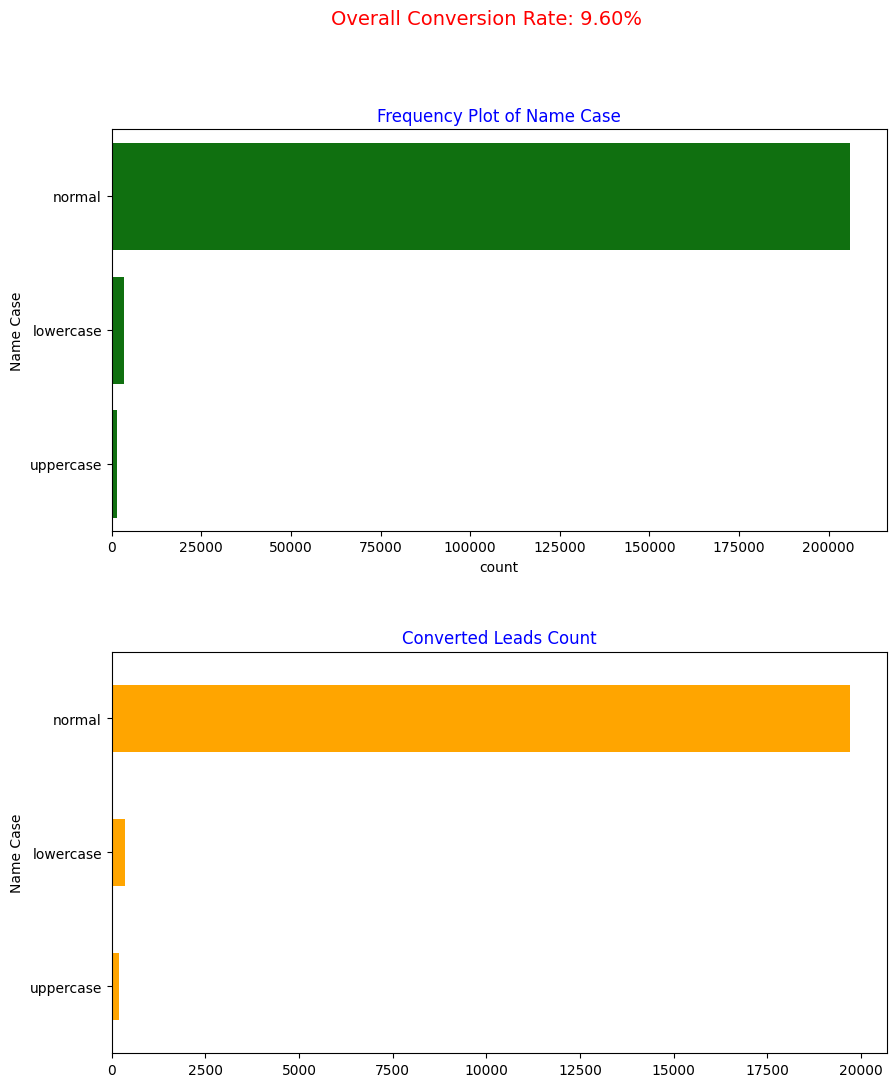

In [42]:
plot_frequency_and_percentage('Name Case', df, df, True, 6)

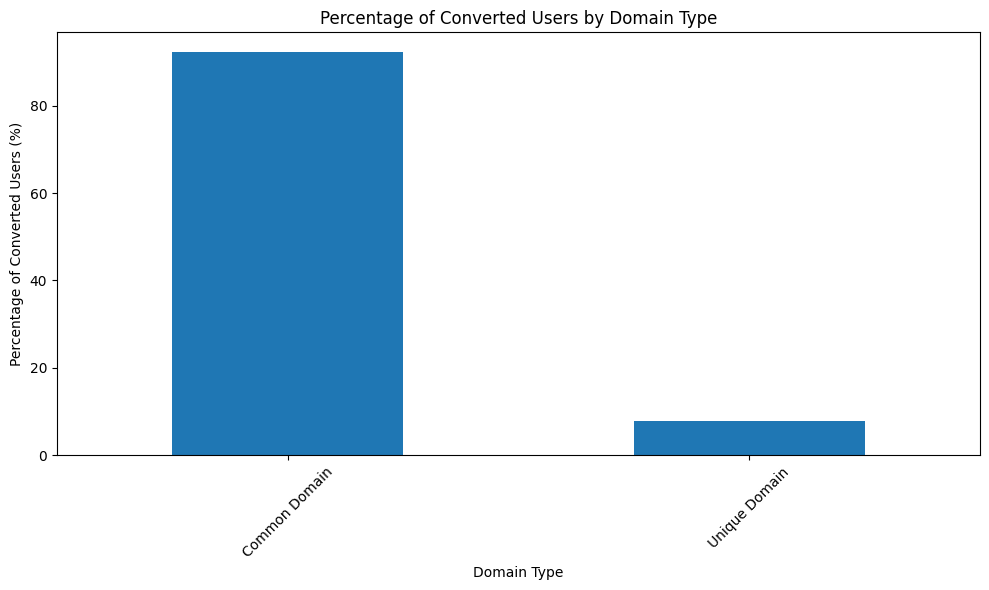

In [43]:
plot_conversion_rate(df, 'is_converted', 'Domain Type')

In [44]:
filtered_df = df[df['is_converted'] == True]

# Step 3: Calculate the mean of 's_onTime' for the filtered DataFrame
s_onTime_mean_filtered = filtered_df['Sum of Study Interests'].mean()
print(s_onTime_mean_filtered)

1.1147670569635888


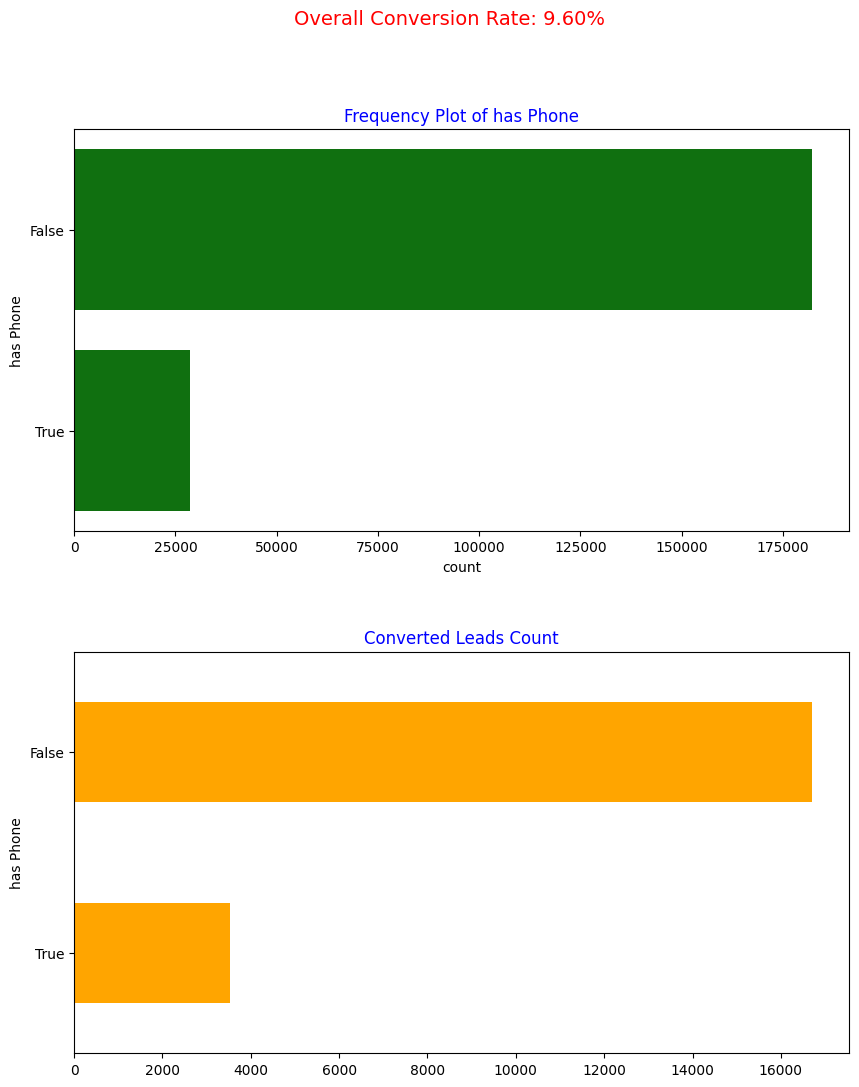

In [45]:
plot_frequency_and_percentage('has Phone', df, df, True, 6)

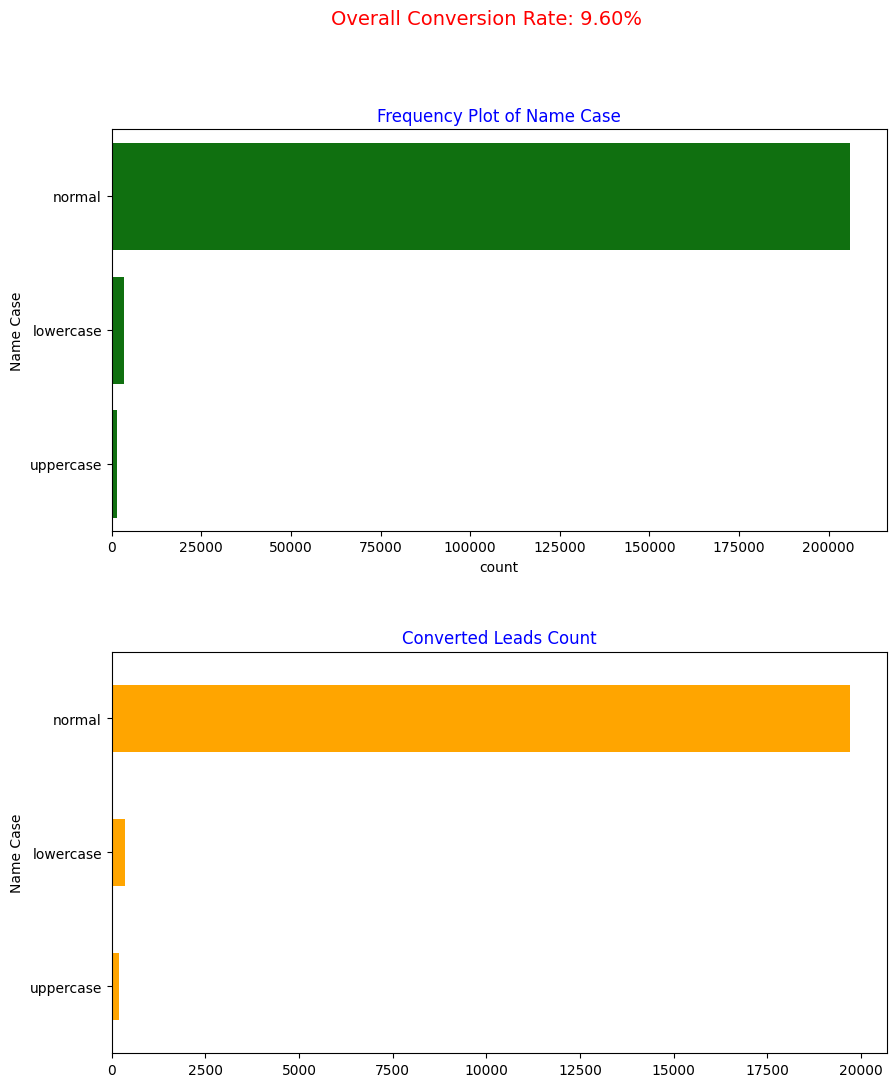

In [46]:
plot_frequency_and_percentage('Name Case', df, df, True, 6)

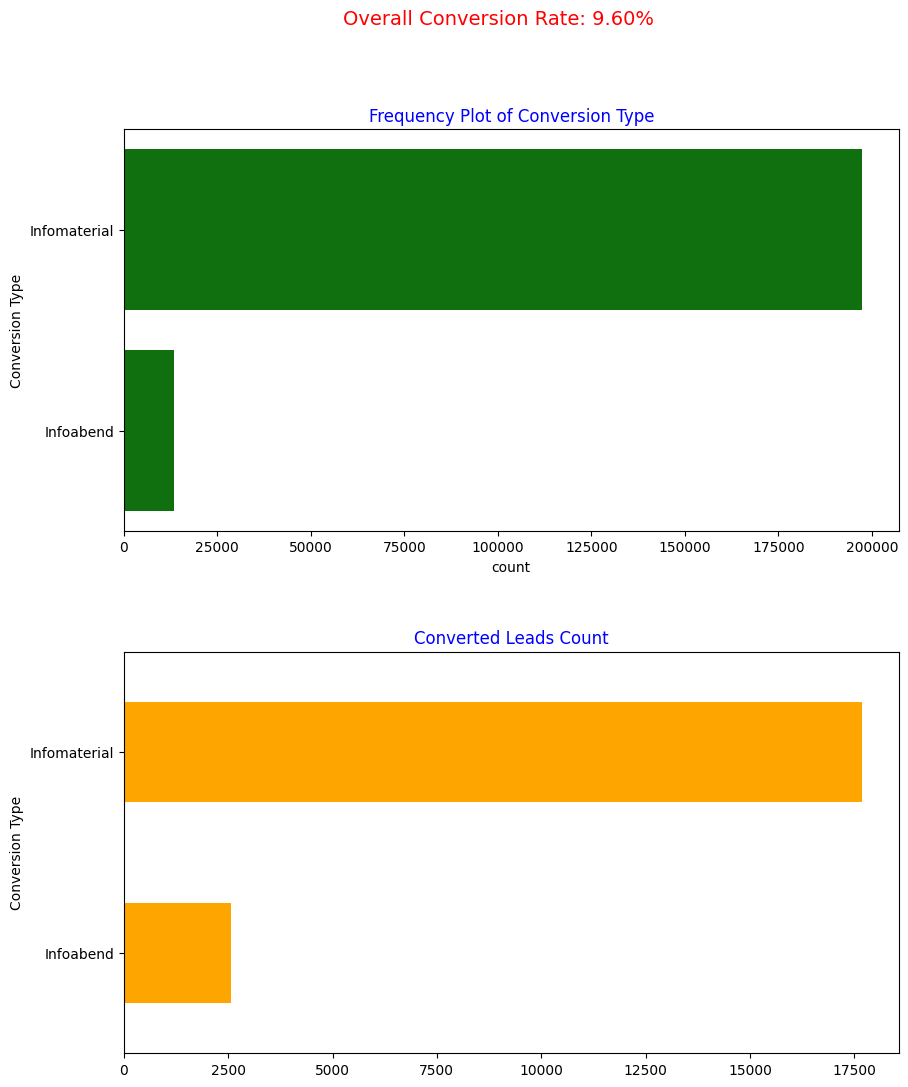

In [47]:
plot_frequency_and_percentage('Conversion Type', df, df, True, 6)

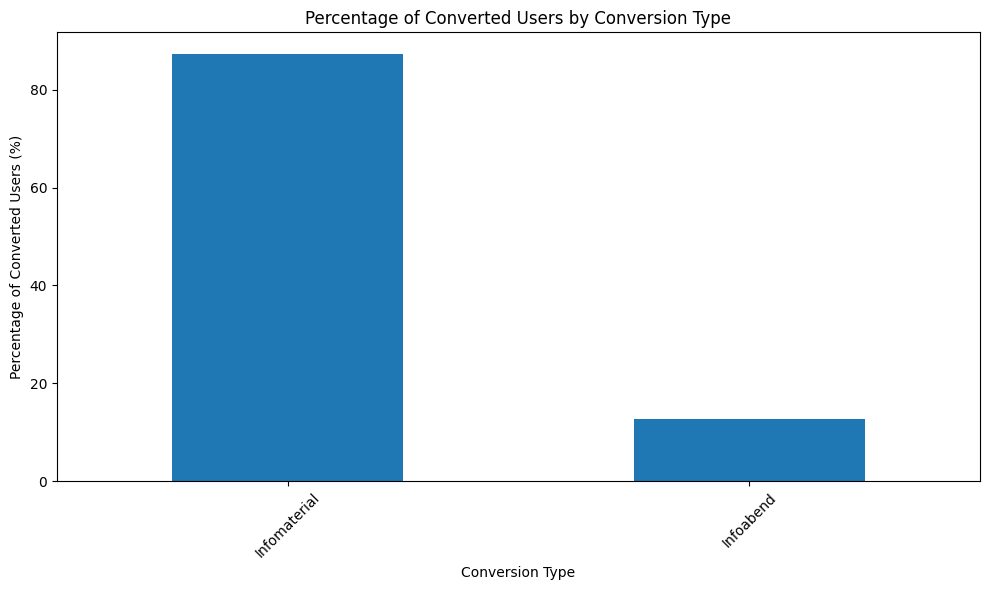

In [48]:
plot_conversion_rate(df, 'is_converted', 'Conversion Type')

In [49]:
!pip install category_encoders --q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.0 MB/s eta 0:00:00


In [50]:
# Import necessary libraries
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
import category_encoders as ce

In [51]:
df.dtypes

Lead Source                object
Lead Source Detail         object
Name Case                  object
Domain Type                object
Gender                     object
Host                       object
has Phone                 boolean
Accept Data Policy        boolean
Conversion Type            object
Study Model                object
Type of Study Program      object
Study Location             object
Faculty                    object
Study Program              object
Semester                   object
is_converted              boolean
Sum of Study Interests      Int64
dtype: object

In [52]:
df.nunique()

Lead Source                24
Lead Source Detail        505
Name Case                   3
Domain Type                 2
Gender                      4
Host                       11
has Phone                   2
Accept Data Policy          2
Conversion Type             2
Study Model                 5
Type of Study Program       6
Study Location             19
Faculty                    10
Study Program             192
Semester                    2
is_converted                2
Sum of Study Interests     11
dtype: int64

In [53]:
# Step 1: Drop 'is_converted' column from df and assign to X
X = df.drop(columns=['is_converted'])

# Step 2: Extract 'is_converted' column from df and assign to y
y = df['is_converted']

In [54]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
# Step 4: Binary Encoding for specified columns
binary_features = ['Host', 'Conversion Type', 'Gender', 'Study Model', 'Faculty', 'Study Location', 'Type of Study Program',
                   'Lead Source', 'Accept Data Policy', 'has Phone', 'Domain Type', 'Name Case', 'Semester', 'Study Program', 'Lead Source Detail']
encoder_target = ce.TargetEncoder(cols=binary_features)
X = encoder_target.fit_transform(X, y)

In [55]:
# Scale the numerical features
scaler = StandardScaler()
X['Sum of Study Interests'] = scaler.fit_transform(X[['Sum of Study Interests']])

# Define the encoded and scaled dataframe as X_prep
X_prep = X

In [56]:
lb = LabelEncoder()
lb.fit(y)
y_encoded = lb.transform(y)
print("Encoded labels:",lb.classes_)
y_en = pd.Series(y_encoded)

Encoded labels: [0. 1.]


In [57]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_prep, y_en, test_size=0.3, stratify=y, random_state=42)


print("Training Data Shape : ", X_train.shape, y_train.shape)
print("Test Data Shape : ", X_test.shape, y_test.shape)

Training Data Shape :  (147557, 16) (147557,)
Test Data Shape :  (63240, 16) (63240,)


In [58]:
#!pip uninstall scikeras

In [59]:
!pip install imbalanced-learn


In [60]:
from imblearn.over_sampling import SMOTE
smote= SMOTE(random_state=42)
# Fit and resample the training data
X_train, y_train = smote.fit_resample(X_train, y_train)

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7c270887c0d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1175, in _make_controller_from_path
    lib_controller = controller_class(
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: /usr/local/lib/python3.10/dist-packages/numpy.libs/libopenblas64_p-r0-5007b62f.3.23.dev.so: cannot open shared object file: No such file or directory


In [61]:
print("Training Data Shape : ", X_train.shape, y_train.shape)
print("Test Data Shape : ", X_test.shape, y_test.shape)

Training Data Shape :  (266776, 16) (266776,)
Test Data Shape :  (63240, 16) (63240,)


In [62]:
# Compute Mutual Information scores
mi_classification = mutual_info_classif(X_train, y_train, discrete_features='auto')

# Create a pandas Series with the MI scores and the feature names
mi_series = pd.Series(mi_classification, index=X_train.columns)

# Exclude the specified column
mi_series = mi_series.drop(labels='Sum of Study Interests')

# Sort the MI scores in descending order and convert to a DataFrame
data_mi = mi_series.sort_values(ascending=False).to_frame(name='MI')

# Display the DataFrame
print(data_mi)


                             MI
Study Program          0.221664
Study Location         0.139342
Lead Source Detail     0.115116
Type of Study Program  0.068746
Faculty                0.061424
Lead Source            0.060289
Gender                 0.051917
Study Model            0.044439
has Phone              0.041426
Name Case              0.039878
Domain Type            0.038847
Host                   0.035811
Accept Data Policy     0.033574
Semester               0.032689
Conversion Type        0.029920


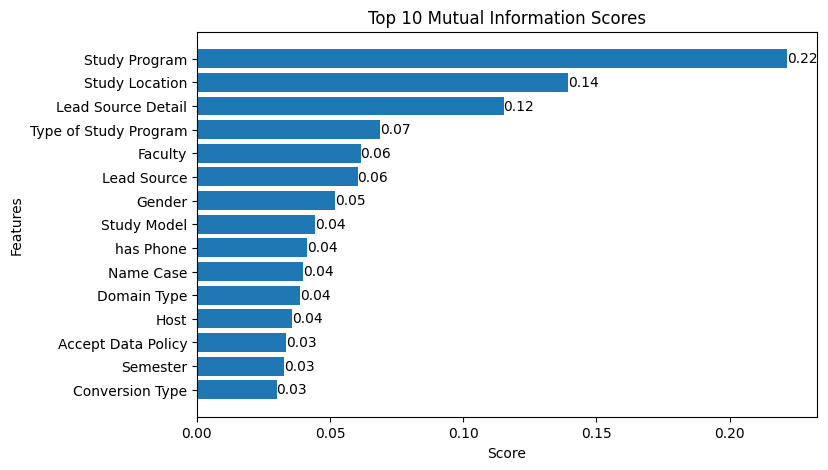

In [63]:
import numpy as np
import matplotlib.pyplot as plt

# Function to plot the Mutual Information scores
def plot_mi_scores(scores):
    # Select top 10 scores
    top_scores = scores.sort_values(ascending=False).head(30)
    sorted_scores = top_scores.sort_values(ascending=True)
    width = np.arange(len(sorted_scores))
    ticks = sorted_scores.index
    plt.barh(width, sorted_scores)
    plt.yticks(width, ticks)
    plt.title("Top 10 Mutual Information Scores")
    plt.xlabel("Score")
    plt.ylabel("Features")

    # Add text annotations for the bar values
    for index, value in enumerate(sorted_scores):
        plt.text(value, index, f'{value:.2f}', va='center', ha='left')

    plt.show()

# Plot the Mutual Information scores
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_series)



In [64]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.feature_selection import f_classif
from scipy import stats

X = df[['Sum of Study Interests']]
y = df['is_converted']

# Apply ANOVA F-test
f_values, p_values = f_classif(X, y)

# Create a DataFrame to display the F-scores and p-values for the specific feature
anova_results = pd.DataFrame({
    'Feature': ['Sum of Study Interests'],
    'F-Score': f_values,
    'p-Value': p_values
})

# Select the feature (in this case, it's already just one)
selected_feature = anova_results.iloc[0]

print("Selected feature based on ANOVA F-test:")
print(selected_feature)

Selected feature based on ANOVA F-test:
Feature    Sum of Study Interests
F-Score                 993.49306
p-Value                       0.0
Name: 0, dtype: object


In [65]:
# Function to evaluate models
def evaluate_model(model, X_test, y_test, model_name):
    predictions = model.predict(X_test)
    if hasattr(model, 'predict_proba'):
        proba = model.predict_proba(X_test)[:, 1]
    else:
        proba = model.predict(X_test)

    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    roc_auc = roc_auc_score(y_test, proba)

    cm = confusion_matrix(y_test, predictions)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)

    print(f"{model_name} Metrics:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall (Sensitivity): {recall}")
    print(f"F1-Score: {f1}")
    print(f"Specificity: {specificity}")
    print(f"ROC AUC: {roc_auc}")

    fpr, tpr, _ = roc_curve(y_test, proba)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='blue', label=f"{model_name} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend()
    plt.show()

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Converted', 'Converted'], yticklabels=['Not Converted', 'Converted'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'specificity': specificity
    }

In [66]:
# Define the DNN model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam, SGD
# Define the DNN model
# Define the DNN model
def create_dnn_model(input_dim, num_neurons_1=32, num_neurons_2=16, activation_1='relu', activation_2='relu', optimizer='adam', dropout_rate=0.0, learning_rate=0.001, momentum=0.0):
    model = Sequential()
    model.add(Dense(num_neurons_1, activation=activation_1, input_dim=input_dim))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_neurons_2, activation=activation_2))
    model.add(Dense(1, activation='sigmoid'))

    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate, momentum=momentum)
    else:
        raise ValueError("Optimizer not recognized")

    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [67]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
# Pipelines for each model
pipeline_xgb = Pipeline([
    ('clf', xgb.XGBClassifier())
])

pipeline_rf = Pipeline([
    ('clf', RandomForestClassifier())
])

pipeline_dt = Pipeline([
    ('clf', DecisionTreeClassifier())
])


pipeline_dnn = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', KerasClassifier(build_fn=create_dnn_model, input_dim=X_train.shape[1], verbose=0,))
])

<ipython-input-67-72dfe8fe0dd3>:21: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  ('clf', KerasClassifier(build_fn=create_dnn_model, input_dim=X_train.shape[1], verbose=0,))


In [68]:
model_performance = {}

XGBoost Metrics:
Accuracy: 0.8226438962681847
Precision: 0.20845613239628202
Recall (Sensitivity): 0.3028656126482213
F1-Score: 0.24694507855512285
Specificity: 0.8778512454520011
ROC AUC: 0.689393438132281


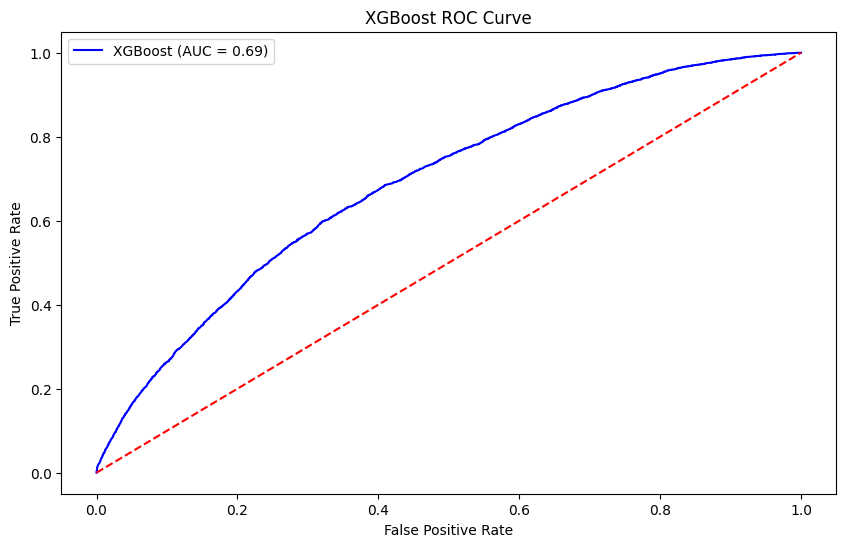

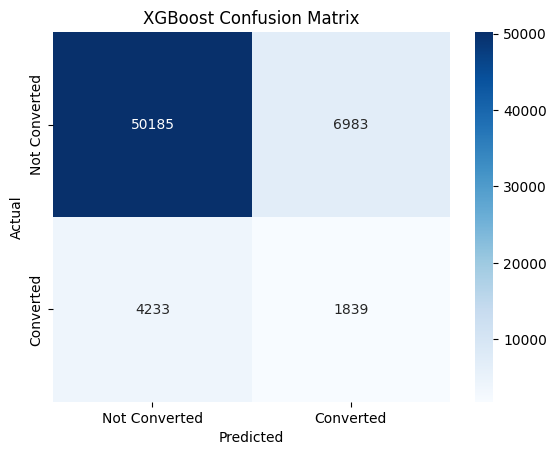

In [69]:

# Train and evaluate XGBoost
model_performance['XGBoost'] = evaluate_model(pipeline_xgb.fit(X_train, y_train),X_test, y_test, "XGBoost")

RandomForest Metrics:
Accuracy: 0.8188013915243517
Precision: 0.18742021585238483
Recall (Sensitivity): 0.2659749670619236
F1-Score: 0.21989243651712168
Specificity: 0.8775188916876574
ROC AUC: 0.6377071270788415


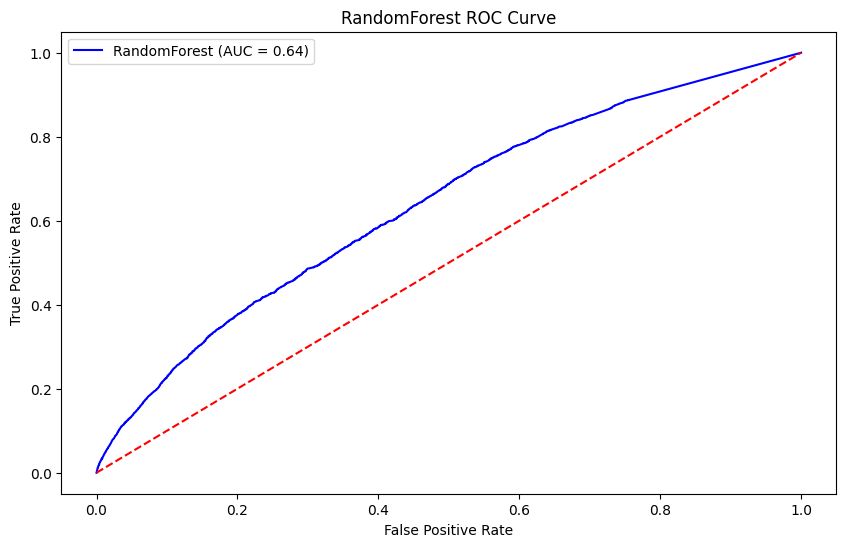

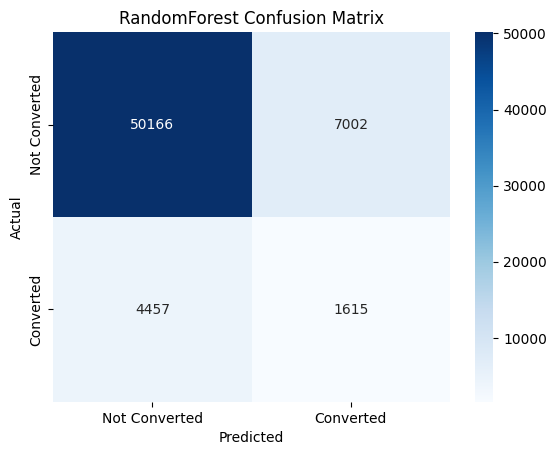

In [70]:
# Train and evaluate RandomForest
model_performance['RandomForest'] = evaluate_model(pipeline_rf.fit(X_train, y_train), X_test, y_test, "RandomForest")

DecisionTree Metrics:
Accuracy: 0.8133776091081594
Precision: 0.18328543002432013
Recall (Sensitivity): 0.2730566534914361
F1-Score: 0.21934118269612382
Specificity: 0.8707668625804645
ROC AUC: 0.5895321640247067


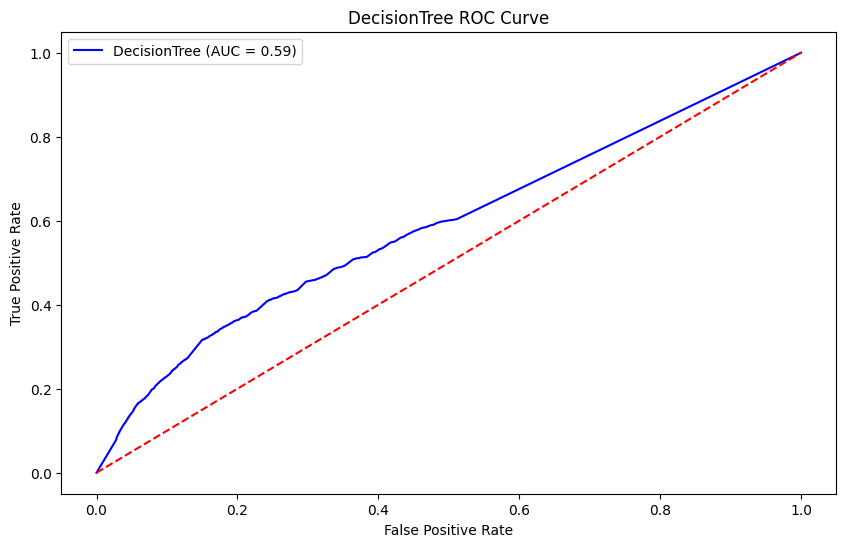

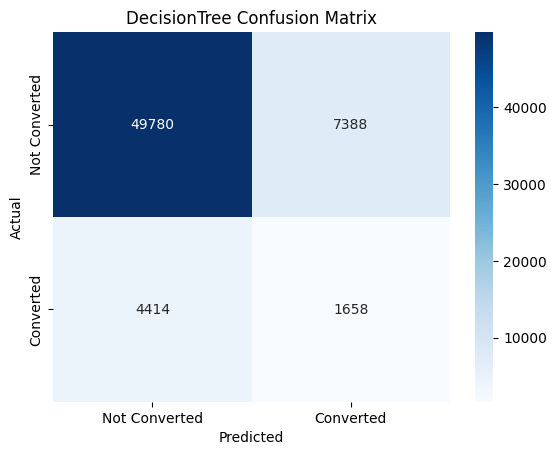

In [71]:

# Train and evaluate DecisionTree
model_performance['DecisionTree'] = evaluate_model(pipeline_dt.fit(X_train, y_train), X_test, y_test, "DecisionTree")

1977/1977 [==============================] - 2s 901us/step
Deep Neural Network Metrics:
Accuracy: 0.6596141682479444
Precision: 0.17358060155457924
Recall (Sensitivity): 0.6767127799736495
F1-Score: 0.27629101667563205
Specificity: 0.6577980688497062
ROC AUC: 0.7267581447298894


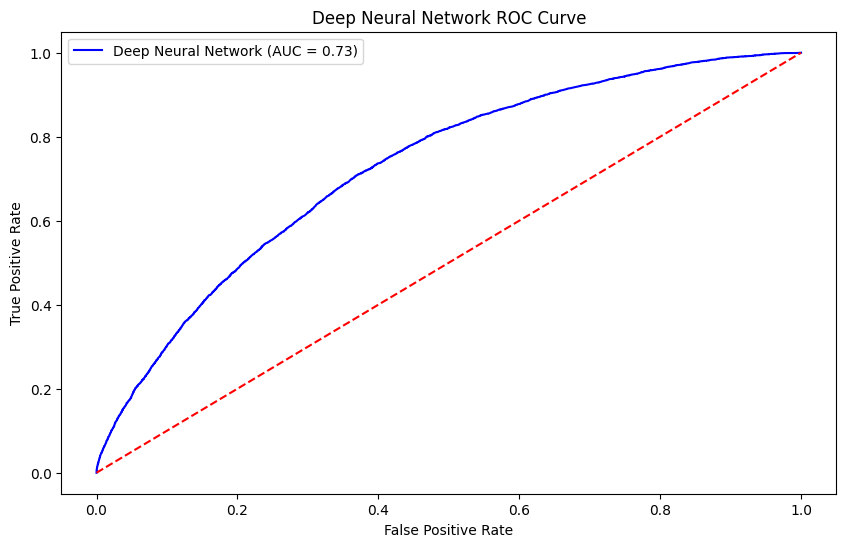

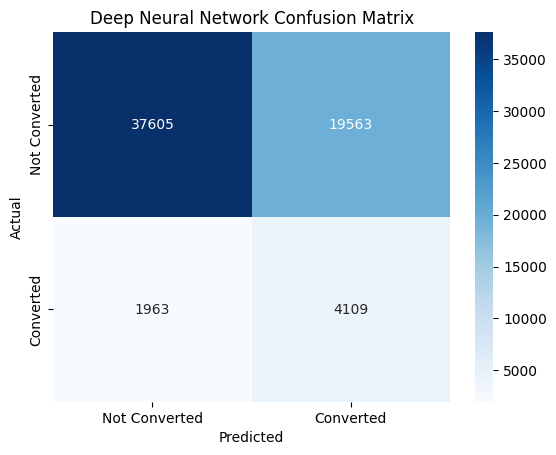

In [72]:
model_performance['DNN'] = evaluate_model(pipeline_dnn.fit(X_train, y_train), X_test, y_test, "Deep Neural Network")

In [73]:
# Print the performance metrics
for model_name, metrics in model_performance.items():
    print(f"\n{model_name} Performance:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")


XGBoost Performance:
accuracy: 0.8226
precision: 0.2085
recall: 0.3029
f1: 0.2469
roc_auc: 0.6894
specificity: 0.8779

RandomForest Performance:
accuracy: 0.8188
precision: 0.1874
recall: 0.2660
f1: 0.2199
roc_auc: 0.6377
specificity: 0.8775

DecisionTree Performance:
accuracy: 0.8134
precision: 0.1833
recall: 0.2731
f1: 0.2193
roc_auc: 0.5895
specificity: 0.8708

DNN Performance:
accuracy: 0.6596
precision: 0.1736
recall: 0.6767
f1: 0.2763
roc_auc: 0.7268
specificity: 0.6578


In [74]:
# Convert the model performance dictionary to a DataFrame
results_df = pd.DataFrame(model_performance).T

# Save the DataFrame to an Excel file
results_df.to_excel('model_performance_results5.xlsx', index=True)
print("Model performance results saved to 'model_performance_results_final.xlsx'.")

Model performance results saved to 'model_performance_results_final.xlsx'.


In [75]:
print(model_performance['DNN'])

{'accuracy': 0.6596141682479444, 'precision': 0.17358060155457924, 'recall': 0.6767127799736495, 'f1': 0.27629101667563205, 'roc_auc': 0.7267581447298894, 'specificity': 0.6577980688497062}


In [89]:
from scipy.stats import uniform

# Stronger parameter grid for XGBoost
param_extreme_xgb = {
    'clf__max_depth': [1, 3, 5, 7, 9, 11, 13],
    'clf__learning_rate': uniform(0.0001, 0.5),
    'clf__n_estimators': [50, 100, 200, 300, 500],
    'clf__subsample': uniform(0.1, 0.9),
    'clf__colsample_bytree': uniform(0.1, 0.9),
    'clf__gamma': uniform(0, 1),
    'clf__min_child_weight': [1, 3, 5, 7, 9],
    'clf__reg_alpha': uniform(0, 1),
    'clf__reg_lambda': uniform(0, 2)
}

# Stronger parameter grid for Random Forest
param_extreme_rf = {
    'clf__n_estimators': [50, 100, 200, 300, 500, 1000],
    'clf__max_depth': [None, 5, 10, 20, 30, 40, 50],
    'clf__min_samples_split': [2, 5, 10, 15, 20],
    'clf__min_samples_leaf': [1, 2, 4, 8],
    'clf__max_features': ['auto', 'sqrt', 'log2', None],
    'clf__bootstrap': [True, False]
}

# Stronger parameter grid for Deep Neural Networks
param_extreme_dnn = {
    'clf__num_neurons_1': [32, 64, 128, 256],
    'clf__num_neurons_2': [16, 32, 64, 128],
    'clf__activation_1': ['relu', 'tanh', 'sigmoid'],
    'clf__activation_2': ['relu', 'tanh', 'sigmoid'],
    'clf__dropout_rate': [0.2, 0.3, 0.4, 0.5],
    'clf__optimizer': ['adam', 'sgd', 'rmsprop'],
    'clf__learning_rate': [0.001, 0.01, 0.1, 0.2],
    'clf__momentum': [0.0, 0.5, 0.9],
    'clf__batch_size': [16, 32, 64, 128],
    'clf__epochs': [10, 50, 100, 200]
}

In [83]:
from keras.callbacks import EarlyStopping
import logging
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from joblib import Parallel, parallel_backend
# Function to perform Randomized Search with early stopping
def perform_random_search_dnn(pipeline, param_distributions, X_train, y_train, n_iter=50):
    logging.info("Starting random search")
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_distributions,
                                       cv=cv, scoring='roc_auc', n_jobs=-1, verbose=2, n_iter=n_iter)

    logging.info("Fitting random search to training data")
    with parallel_backend('threading'):
     random_search.fit(X_train, y_train, clf__validation_split=0.2, clf__callbacks=[early_stopping])

    logging.info("Random search complete")
    return random_search

In [84]:
from sklearn.model_selection import StratifiedKFold
# Function to perform randomized search
def perform_randomized_search(pipeline, param_distributions, X_train, y_train, n_iter=50):
    logging.info("Starting random search")
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_distributions,
                                       n_iter=n_iter, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=2, random_state=42)
    logging.info("Fitting random search to training data")
    with parallel_backend('threading'):
      random_search.fit(X_train, y_train)
    logging.info("Random search complete")
    return random_search

In [90]:
model_performance = {}


In [91]:
random_search_xgb = perform_randomized_search(pipeline_xgb, param_extreme_xgb, X_train, y_train)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END clf__colsample_bytree=0.6410035105688879, clf__gamma=0.7080725777960455, clf__learning_rate=0.010392247147901223, clf__max_depth=3, clf__min_child_weight=7, clf__n_estimators=100, clf__reg_alpha=0.18182496720710062, clf__reg_lambda=0.36680901970686763, clf__subsample=0.373818018663584; total time=   6.0s
[CV] END clf__colsample_bytree=0.6410035105688879, clf__gamma=0.7080725777960455, clf__learning_rate=0.010392247147901223, clf__max_depth=3, clf__min_child_weight=7, clf__n_estimators=100, clf__reg_alpha=0.18182496720710062, clf__reg_lambda=0.36680901970686763, clf__subsample=0.373818018663584; total time=   6.3s
[CV] END clf__colsample_bytree=0.6410035105688879, clf__gamma=0.7080725777960455, clf__learning_rate=0.010392247147901223, clf__max_depth=3, clf__min_child_weight=7, clf__n_estimators=100, clf__reg_alpha=0.18182496720710062, clf__reg_lambda=0.36680901970686763, clf__subsample=0.373818018663584; total time= 

XGBoost Metrics:
Accuracy: 0.8234661606578115
Precision: 0.19618138424821002
Recall (Sensitivity): 0.2707509881422925
F1-Score: 0.2275117630777747
Specificity: 0.8821718443884691
ROC AUC: 0.6537011752131434


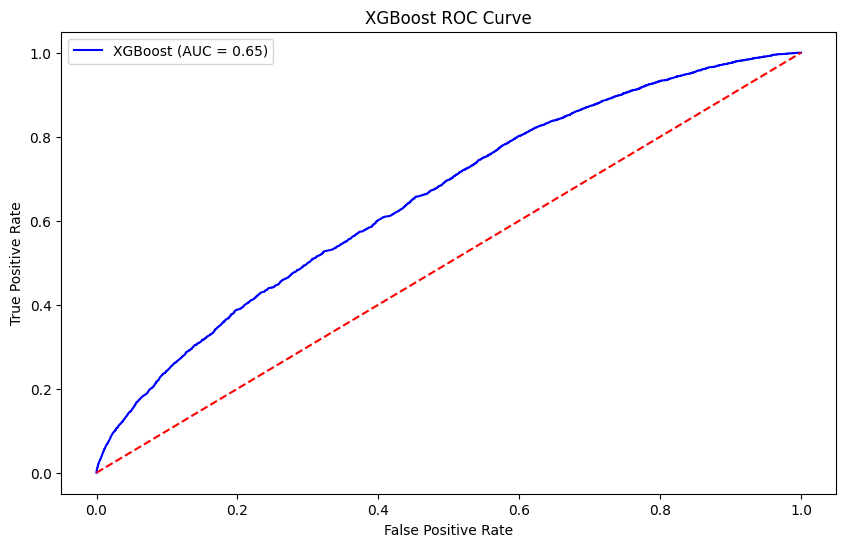

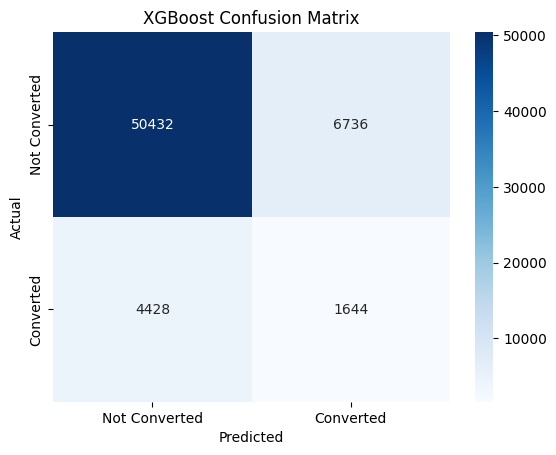

In [92]:
model_performance['XGBoost'] = evaluate_model(random_search_xgb, X_test, y_test, 'XGBoost')

In [93]:
random_search_rf = perform_randomized_search(pipeline_rf, param_extreme_rf, X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

[CV] END clf__bootstrap=False, clf__max_depth=20, clf__max_features=None, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=50; total time= 1.9min
[CV] END clf__bootstrap=False, clf__max_depth=20, clf__max_features=None, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=50; total time= 1.9min
[CV] END clf__bootstrap=True, clf__max_depth=5, clf__max_features=None, clf__min_samples_leaf=1, clf__min_samples_split=15, clf__n_estimators=200; total time= 2.3min
[CV] END clf__bootstrap=True, clf__max_depth=5, clf__max_features=None, clf__min_samples_leaf=1, clf__min_samples_split=15, clf__n_estimators=200; total time= 2.3min
[CV] END clf__bootstrap=True, clf__max_depth=5, clf__max_features=None, clf__min_samples_leaf=1, clf__min_samples_split=15, clf__n_estimators=200; total time= 2.3min
[CV] END clf__bootstrap=True, clf__max_depth=5, clf__max_features=None, clf__min_samples_leaf=1, clf__min_samples_split=15, clf__n_estimators=200; total time= 2.3min
[CV]

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=True, clf__max_depth=50, clf__max_features=sqrt, clf__min_samples_leaf=8, clf__min_samples_split=2, clf__n_estimators=200; total time= 2.1min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=False, clf__max_depth=40, clf__max_features=auto, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=1500; total time=19.6min
[CV] END clf__bootstrap=False, clf__max_depth=40, clf__max_features=auto, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=1500; total time=19.7min
[CV] END clf__bootstrap=False, clf__max_depth=40, clf__max_features=auto, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=1500; total time=19.7min
[CV] END clf__bootstrap=False, clf__max_depth=40, clf__max_features=auto, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=1500; total time=19.8min
[CV] END clf__bootstrap=False, clf__max_depth=40, clf__max_features=auto, clf__min_samples_leaf=4, clf__min_samples_split=10, clf__n_estimators=1500; total time=19.8min
[CV] END clf__bootstrap=False, clf__max_depth=50, clf__max_features=auto, clf__min_samples_leaf=1, clf__min_samples_split=20, clf__n_estimators=100; total 

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=False, clf__max_depth=50, clf__max_features=auto, clf__min_samples_leaf=1, clf__min_samples_split=20, clf__n_estimators=100; total time= 1.2min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=False, clf__max_depth=50, clf__max_features=auto, clf__min_samples_leaf=1, clf__min_samples_split=20, clf__n_estimators=100; total time= 1.0min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=False, clf__max_depth=50, clf__max_features=auto, clf__min_samples_leaf=1, clf__min_samples_split=20, clf__n_estimators=100; total time= 1.0min
[CV] END clf__bootstrap=False, clf__max_depth=50, clf__max_features=auto, clf__min_samples_leaf=1, clf__min_samples_split=20, clf__n_estimators=100; total time=  59.2s
[CV] END clf__bootstrap=False, clf__max_depth=None, clf__max_features=None, clf__min_samples_leaf=2, clf__min_samples_split=15, clf__n_estimators=500; total time=15.9min
[CV] END clf__bootstrap=False, clf__max_depth=None, clf__max_features=None, clf__min_samples_leaf=2, clf__min_samples_split=15, clf__n_estimators=500; total time=16.1min
[CV] END clf__bootstrap=False, clf__max_depth=None, clf__max_features=None, clf__min_samples_leaf=2, clf__min_samples_split=15, clf__n_estimators=500; total time=16.5min
[CV] END clf__bootstrap=False, clf__max_depth=None, clf__max_features=None, clf__min_samples_leaf=2, clf__min_samples_split=15, clf__n_estimators=500; tot

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=False, clf__max_depth=None, clf__max_features=None, clf__min_samples_leaf=2, clf__min_samples_split=15, clf__n_estimators=500; total time=15.7min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=False, clf__max_depth=30, clf__max_features=auto, clf__min_samples_leaf=2, clf__min_samples_split=20, clf__n_estimators=50; total time=  29.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=False, clf__max_depth=30, clf__max_features=auto, clf__min_samples_leaf=2, clf__min_samples_split=20, clf__n_estimators=50; total time=  29.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=False, clf__max_depth=30, clf__max_features=auto, clf__min_samples_leaf=2, clf__min_samples_split=20, clf__n_estimators=50; total time=  29.0s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=True, clf__max_depth=None, clf__max_features=None, clf__min_samples_leaf=8, clf__min_samples_split=10, clf__n_estimators=500; total time= 9.7min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=False, clf__max_depth=30, clf__max_features=auto, clf__min_samples_leaf=2, clf__min_samples_split=20, clf__n_estimators=50; total time=  29.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=False, clf__max_depth=30, clf__max_features=auto, clf__min_samples_leaf=2, clf__min_samples_split=20, clf__n_estimators=50; total time=  30.2s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=False, clf__max_depth=30, clf__max_features=None, clf__min_samples_leaf=8, clf__min_samples_split=2, clf__n_estimators=500; total time=14.8min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=True, clf__max_depth=None, clf__max_features=None, clf__min_samples_leaf=8, clf__min_samples_split=10, clf__n_estimators=500; total time= 9.6min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=False, clf__max_depth=30, clf__max_features=None, clf__min_samples_leaf=8, clf__min_samples_split=2, clf__n_estimators=500; total time=15.0min
[CV] END clf__bootstrap=False, clf__max_depth=30, clf__max_features=None, clf__min_samples_leaf=8, clf__min_samples_split=2, clf__n_estimators=500; total time=15.0min
[CV] END clf__bootstrap=False, clf__max_depth=30, clf__max_features=None, clf__min_samples_leaf=8, clf__min_samples_split=2, clf__n_estimators=500; total time=15.2min
[CV] END clf__bootstrap=False, clf__max_depth=30, clf__max_features=None, clf__min_samples_leaf=8, clf__min_samples_split=2, clf__n_estimators=500; total time=14.2min
[CV] END clf__bootstrap=False, clf__max_depth=10, clf__max_features=auto, clf__min_samples_leaf=8, clf__min_samples_split=10, clf__n_estimators=500; total time= 2.9min
[CV] END clf__bootstrap=False, clf__max_depth=10, clf__max_features=auto, clf__min_samples_leaf=8, clf__min_samples_split=10, clf__n_estimators=500; total time= 2.9

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=False, clf__max_depth=None, clf__max_features=auto, clf__min_samples_leaf=4, clf__min_samples_split=20, clf__n_estimators=50; total time=  29.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=False, clf__max_depth=30, clf__max_features=log2, clf__min_samples_leaf=2, clf__min_samples_split=20, clf__n_estimators=500; total time= 4.9min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=False, clf__max_depth=30, clf__max_features=log2, clf__min_samples_leaf=2, clf__min_samples_split=20, clf__n_estimators=500; total time= 4.9min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=False, clf__max_depth=None, clf__max_features=auto, clf__min_samples_leaf=4, clf__min_samples_split=20, clf__n_estimators=50; total time=  28.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=False, clf__max_depth=None, clf__max_features=auto, clf__min_samples_leaf=4, clf__min_samples_split=20, clf__n_estimators=50; total time=  28.8s
[CV] END clf__bootstrap=False, clf__max_depth=None, clf__max_features=auto, clf__min_samples_leaf=4, clf__min_samples_split=20, clf__n_estimators=50; total time=  28.9s
[CV] END clf__bootstrap=False, clf__max_depth=None, clf__max_features=auto, clf__min_samples_leaf=4, clf__min_samples_split=20, clf__n_estimators=50; total time=  29.1s
[CV] END clf__bootstrap=False, clf__max_depth=30, clf__max_features=log2, clf__min_samples_leaf=2, clf__min_samples_split=20, clf__n_estimators=500; total time= 4.7min
[CV] END clf__bootstrap=True, clf__max_depth=None, clf__max_features=None, clf__min_samples_leaf=8, clf__min_samples_split=10, clf__n_estimators=500; total time= 9.7min
[CV] END clf__bootstrap=True, clf__max_depth=None, clf__max_features=None, clf__min_samples_leaf=8, clf__min_samples_split=10, clf__n_estimators=500; total 

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=True, clf__max_depth=None, clf__max_features=None, clf__min_samples_leaf=8, clf__min_samples_split=10, clf__n_estimators=500; total time=10.0min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=True, clf__max_depth=50, clf__max_features=log2, clf__min_samples_leaf=2, clf__min_samples_split=15, clf__n_estimators=300; total time= 2.2min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=True, clf__max_depth=50, clf__max_features=log2, clf__min_samples_leaf=2, clf__min_samples_split=15, clf__n_estimators=300; total time= 2.2min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=True, clf__max_depth=50, clf__max_features=log2, clf__min_samples_leaf=2, clf__min_samples_split=15, clf__n_estimators=300; total time= 2.1min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=True, clf__max_depth=50, clf__max_features=log2, clf__min_samples_leaf=2, clf__min_samples_split=15, clf__n_estimators=300; total time= 2.2min
[CV] END clf__bootstrap=True, clf__max_depth=50, clf__max_features=log2, clf__min_samples_leaf=2, clf__min_samples_split=15, clf__n_estimators=300; total time= 2.2min
[CV] END clf__bootstrap=True, clf__max_depth=50, clf__max_features=auto, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=300; total time= 2.2min
[CV] END clf__bootstrap=True, clf__max_depth=50, clf__max_features=auto, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=300; total time= 2.2min
[CV] END clf__bootstrap=False, clf__max_depth=40, clf__max_features=None, clf__min_samples_leaf=8, clf__min_samples_split=15, clf__n_estimators=300; total time= 8.4min
[CV] END clf__bootstrap=True, clf__max_depth=50, clf__max_features=auto, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=300; total time= 2.3min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=False, clf__max_depth=30, clf__max_features=log2, clf__min_samples_leaf=8, clf__min_samples_split=2, clf__n_estimators=100; total time=  54.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=True, clf__max_depth=20, clf__max_features=log2, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=1000; total time= 6.7min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=True, clf__max_depth=20, clf__max_features=log2, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=1000; total time= 7.0min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=True, clf__max_depth=20, clf__max_features=log2, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=1000; total time= 6.7min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=True, clf__max_depth=20, clf__max_features=log2, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=1000; total time= 6.9min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=True, clf__max_depth=40, clf__max_features=auto, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=300; total time= 2.2min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=True, clf__max_depth=20, clf__max_features=log2, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=1000; total time= 7.0min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=True, clf__max_depth=30, clf__max_features=None, clf__min_samples_leaf=8, clf__min_samples_split=15, clf__n_estimators=300; total time= 6.2min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=False, clf__max_depth=30, clf__max_features=auto, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100; total time= 1.0min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=True, clf__max_depth=40, clf__max_features=auto, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=300; total time= 2.2min
[CV] END clf__bootstrap=True, clf__max_depth=30, clf__max_features=None, clf__min_samples_leaf=8, clf__min_samples_split=15, clf__n_estimators=300; total time= 6.1min
[CV] END clf__bootstrap=True, clf__max_depth=30, clf__max_features=None, clf__min_samples_leaf=8, clf__min_samples_split=15, clf__n_estimators=300; total time= 6.1min
[CV] END clf__bootstrap=False, clf__max_depth=30, clf__max_features=auto, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100; total time= 1.0min
[CV] END clf__bootstrap=False, clf__max_depth=30, clf__max_features=auto, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=100; total time= 1.0min
[CV] END clf__bootstrap=True, clf__max_depth=40, clf__max_features=auto, clf__min_samples_leaf=2, clf__min_samples_split=2, clf__n_estimators=300; total time= 2.2min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=True, clf__max_depth=10, clf__max_features=sqrt, clf__min_samples_leaf=8, clf__min_samples_split=10, clf__n_estimators=200; total time=  53.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=True, clf__max_depth=10, clf__max_features=sqrt, clf__min_samples_leaf=8, clf__min_samples_split=10, clf__n_estimators=200; total time=  54.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=False, clf__max_depth=10, clf__max_features=sqrt, clf__min_samples_leaf=8, clf__min_samples_split=20, clf__n_estimators=100; total time=  35.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=False, clf__max_depth=10, clf__max_features=sqrt, clf__min_samples_leaf=8, clf__min_samples_split=20, clf__n_estimators=100; total time=  35.4s
[CV] END clf__bootstrap=False, clf__max_depth=10, clf__max_features=sqrt, clf__min_samples_leaf=8, clf__min_samples_split=20, clf__n_estimators=100; total time=  35.4s
[CV] END clf__bootstrap=False, clf__max_depth=5, clf__max_features=log2, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=100; total time=  19.3s
[CV] END clf__bootstrap=False, clf__max_depth=5, clf__max_features=log2, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=100; total time=  19.9s
[CV] END clf__bootstrap=False, clf__max_depth=None, clf__max_features=auto, clf__min_samples_leaf=1, clf__min_samples_split=20, clf__n_estimators=100; total time= 1.0min
[CV] END clf__bootstrap=False, clf__max_depth=None, clf__max_features=auto, clf__min_samples_leaf=1, clf__min_samples_split=20, clf__n_estimators=100; total time=

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=False, clf__max_depth=None, clf__max_features=auto, clf__min_samples_leaf=1, clf__min_samples_split=20, clf__n_estimators=100; total time= 1.0min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=False, clf__max_depth=50, clf__max_features=sqrt, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=50; total time=  29.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=False, clf__max_depth=50, clf__max_features=sqrt, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=50; total time=  29.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=False, clf__max_depth=50, clf__max_features=sqrt, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=50; total time=  30.4s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=False, clf__max_depth=50, clf__max_features=sqrt, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=50; total time=  31.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=False, clf__max_depth=50, clf__max_features=sqrt, clf__min_samples_leaf=2, clf__min_samples_split=5, clf__n_estimators=50; total time=  30.8s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=True, clf__max_depth=50, clf__max_features=auto, clf__min_samples_leaf=1, clf__min_samples_split=20, clf__n_estimators=50; total time=  22.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=True, clf__max_depth=50, clf__max_features=auto, clf__min_samples_leaf=1, clf__min_samples_split=20, clf__n_estimators=50; total time=  22.5s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=False, clf__max_depth=20, clf__max_features=auto, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=100; total time=  53.6s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=False, clf__max_depth=20, clf__max_features=auto, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=100; total time=  53.0s
[CV] END clf__bootstrap=False, clf__max_depth=20, clf__max_features=auto, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=100; total time=  51.7s
[CV] END clf__bootstrap=False, clf__max_depth=20, clf__max_features=auto, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=100; total time=  52.1s
[CV] END clf__bootstrap=True, clf__max_depth=50, clf__max_features=auto, clf__min_samples_leaf=1, clf__min_samples_split=20, clf__n_estimators=50; total time=  22.7s
[CV] END clf__bootstrap=True, clf__max_depth=50, clf__max_features=auto, clf__min_samples_leaf=1, clf__min_samples_split=20, clf__n_estimators=50; total time=  22.7s
[CV] END clf__bootstrap=False, clf__max_depth=20, clf__max_features=auto, clf__min_samples_leaf=2, clf__min_samples_split=10, clf__n_estimators=100; total time=  54

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=True, clf__max_depth=30, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=100; total time=  47.3s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=False, clf__max_depth=20, clf__max_features=log2, clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=1000; total time= 9.1min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=True, clf__max_depth=10, clf__max_features=auto, clf__min_samples_leaf=1, clf__min_samples_split=10, clf__n_estimators=300; total time= 1.4min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=True, clf__max_depth=10, clf__max_features=auto, clf__min_samples_leaf=1, clf__min_samples_split=10, clf__n_estimators=300; total time= 1.4min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=False, clf__max_depth=20, clf__max_features=log2, clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=1000; total time= 9.2min
[CV] END clf__bootstrap=False, clf__max_depth=20, clf__max_features=log2, clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=1000; total time= 9.0min
[CV] END clf__bootstrap=False, clf__max_depth=20, clf__max_features=log2, clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=1000; total time= 9.0min
[CV] END clf__bootstrap=False, clf__max_depth=20, clf__max_features=log2, clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=1000; total time= 9.1min
[CV] END clf__bootstrap=True, clf__max_depth=20, clf__max_features=None, clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=50; total time= 1.0min
[CV] END clf__bootstrap=True, clf__max_depth=20, clf__max_features=None, clf__min_samples_leaf=1, clf__min_samples_split=5, clf__n_estimators=50; total time=  58.0

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=True, clf__max_depth=10, clf__max_features=log2, clf__min_samples_leaf=4, clf__min_samples_split=5, clf__n_estimators=100; total time=  28.7s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=True, clf__max_depth=50, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=1000; total time= 7.8min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=True, clf__max_depth=50, clf__max_features=sqrt, clf__min_samples_leaf=1, clf__min_samples_split=2, clf__n_estimators=1000; total time= 7.9min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=True, clf__max_depth=20, clf__max_features=auto, clf__min_samples_leaf=4, clf__min_samples_split=20, clf__n_estimators=500; total time= 3.3min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=True, clf__max_depth=20, clf__max_features=auto, clf__min_samples_leaf=4, clf__min_samples_split=20, clf__n_estimators=500; total time= 3.3min
[CV] END clf__bootstrap=True, clf__max_depth=20, clf__max_features=None, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=300; total time= 5.7min
[CV] END clf__bootstrap=True, clf__max_depth=20, clf__max_features=None, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=300; total time= 5.6min
[CV] END clf__bootstrap=True, clf__max_depth=20, clf__max_features=None, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=300; total time= 5.5min
[CV] END clf__bootstrap=True, clf__max_depth=20, clf__max_features=None, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=300; total time= 5.4min
[CV] END clf__bootstrap=True, clf__max_depth=20, clf__max_features=None, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=300; total time= 5.7min
[CV

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=True, clf__max_depth=20, clf__max_features=auto, clf__min_samples_leaf=4, clf__min_samples_split=20, clf__n_estimators=500; total time= 3.3min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=True, clf__max_depth=50, clf__max_features=log2, clf__min_samples_leaf=4, clf__min_samples_split=15, clf__n_estimators=500; total time= 3.6min


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=False, clf__max_depth=5, clf__max_features=auto, clf__min_samples_leaf=2, clf__min_samples_split=15, clf__n_estimators=200; total time=  40.1s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=False, clf__max_depth=5, clf__max_features=auto, clf__min_samples_leaf=2, clf__min_samples_split=15, clf__n_estimators=200; total time=  39.9s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END clf__bootstrap=True, clf__max_depth=50, clf__max_features=log2, clf__min_samples_leaf=4, clf__min_samples_split=15, clf__n_estimators=500; total time= 3.5min
[CV] END clf__bootstrap=True, clf__max_depth=50, clf__max_features=log2, clf__min_samples_leaf=4, clf__min_samples_split=15, clf__n_estimators=500; total time= 3.5min
[CV] END clf__bootstrap=True, clf__max_depth=50, clf__max_features=log2, clf__min_samples_leaf=4, clf__min_samples_split=15, clf__n_estimators=500; total time= 3.4min
[CV] END clf__bootstrap=True, clf__max_depth=50, clf__max_features=log2, clf__min_samples_leaf=4, clf__min_samples_split=15, clf__n_estimators=500; total time= 3.4min
[CV] END clf__bootstrap=False, clf__max_depth=5, clf__max_features=auto, clf__min_samples_leaf=2, clf__min_samples_split=15, clf__n_estimators=200; total time=  39.1s
[CV] END clf__bootstrap=False, clf__max_depth=5, clf__max_features=auto, clf__min_samples_leaf=2, clf__min_samples_split=15, clf__n_estimators=200; total time=  39.9

RandomForest Metrics:
Accuracy: 0.8239405439595193
Precision: 0.1939540507859734
Recall (Sensitivity): 0.264163372859025
F1-Score: 0.22367870589875888
Specificity: 0.8833963056255247
ROC AUC: 0.664202209402369


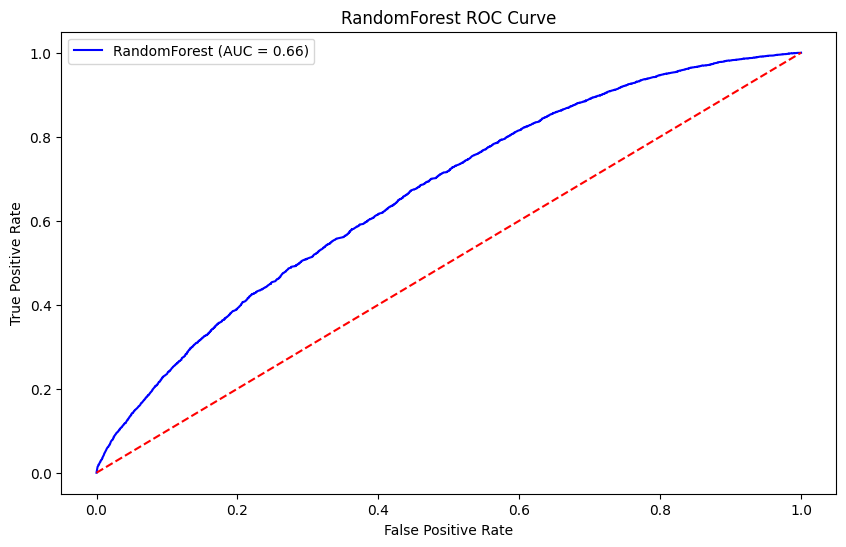

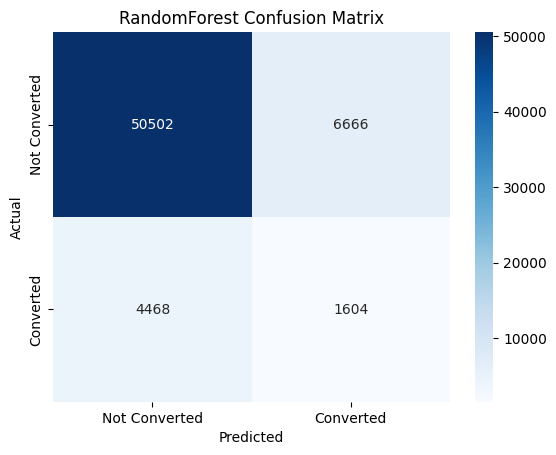

In [94]:
model_performance['RandomForest'] = evaluate_model(random_search_rf, X_test, y_test, 'RandomForest')

In [96]:
random_search_dnn = perform_random_search_dnn(pipeline_dnn, param_extreme_dnn, X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
1668/1668 [==============================] - 18s 11ms/step
[CV] END clf__activation_1=tanh, clf__activation_2=sigmoid, clf__batch_size=64, clf__dropout_rate=0.3, clf__epochs=50, clf__learning_rate=0.1, clf__momentum=0.0, clf__num_neurons_1=64, clf__num_neurons_2=16, clf__optimizer=adam; total time= 3.5min
1668/1668 [==============================] - 18s 11ms/step
[CV] END clf__activation_1=tanh, clf__activation_2=tanh, clf__batch_size=16, clf__dropout_rate=0.4, clf__epochs=50, clf__learning_rate=0.1, clf__momentum=0.5, clf__num_neurons_1=64, clf__num_neurons_2=128, clf__optimizer=sgd; total time= 2.7min
1668/1668 [==============================] - 18s 10ms/step
[CV] END clf__activation_1=tanh, clf__activation_2=tanh, clf__batch_size=16, clf__dropout_rate=0.4, clf__epochs=50, clf__learning_rate=0.1, clf__momentum=0.5, clf__num_neurons_1=64, clf__num_neurons_2=128, clf__optimizer=sgd; total time= 2.3min
1668/1668 [============

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [0.71121694 0.64531592 0.72709377 0.70947476        nan        nan
 0.62195224        nan 0.68769103        nan 0.67452802 0.63390795
 0.72414502        nan        nan 0.50002249 0.71641075        nan
        nan 0.72270635 0.65980913 0.65273053        nan        nan
 0.73420617 0.76445789 0.70987862 0.71439155 0.6844721  0.72446876
        nan        nan 0.61911022 0.70954997        nan 0.72836355
        nan        nan 0.69397164        nan 0.73718378 0.71595285
 0.74126102        nan 0.73710978        nan 0.69345543        nan
 0.70829304        nan]
  warnings.warn(


1977/1977 [==============================] - 2s 953us/step
Deep Neural Network Metrics:
Accuracy: 0.7938488298545224
Precision: 0.20899139299740954
Recall (Sensitivity): 0.4118906455862978
F1-Score: 0.27728809800986753
Specificity: 0.834417856143297
ROC AUC: 0.712360931866856


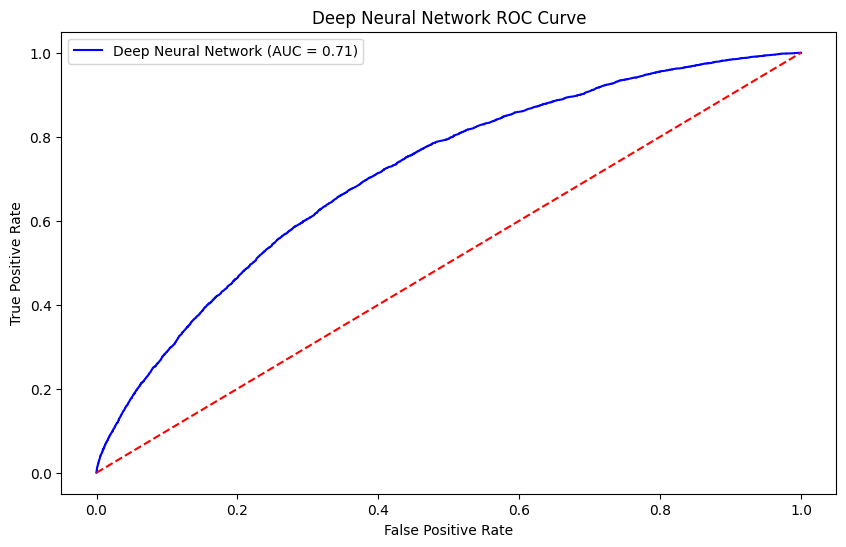

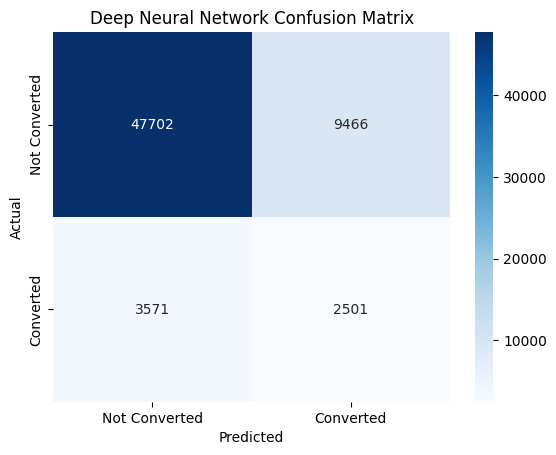

In [97]:
model_performance['DNN'] = evaluate_model(random_search_dnn, X_test, y_test, "Deep Neural Network")

In [98]:
# Print the performance metrics
for model_name, metrics in model_performance.items():
    print(f"\n{model_name} Performance:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")


XGBoost Performance:
accuracy: 0.8235
precision: 0.1962
recall: 0.2708
f1: 0.2275
roc_auc: 0.6537
specificity: 0.8822

RandomForest Performance:
accuracy: 0.8239
precision: 0.1940
recall: 0.2642
f1: 0.2237
roc_auc: 0.6642
specificity: 0.8834

DNN Performance:
accuracy: 0.7938
precision: 0.2090
recall: 0.4119
f1: 0.2773
roc_auc: 0.7124
specificity: 0.8344


In [99]:
# Print the best parameters
print("\nBest Parameters:")
print(perform_randomized_search.best_params_)


Best Parameters:


AttributeError: 'function' object has no attribute 'best_params_'

In [ ]:
# Print the best parameters
print("\nBest Parameters:")
print(perform_random_search_dnn.best_params_)

In [ ]:
# Convert the model performance dictionary to a DataFrame
results_df = pd.DataFrame(model_performance).T

# Save results to an Excel file
results_df.to_excel('model_performance_metrics_final.xlsx', index=True)

# Print results for each model
print("Model Performance Metrics:")
print(results_df)
